In [2]:
import datetime
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler

In [3]:
warnings.filterwarnings('ignore')

## Data load & merge

### Machine data

In [3]:
machine = pd.read_csv('./data/machine_master.csv')
machine.head()

,M_ID,Type,Age
0,1,3,18
1,2,4,7
2,3,3,8
3,4,3,7
4,5,3,2


In [4]:
machine.shape

(100, 3)

In [5]:
# Type는 4가지
machine.Type.unique()

array([3, 4, 2, 1])

### Maint data

In [6]:
maint = pd.read_csv('./data/maint_log.csv')
maint.head()

,DateTime,M_ID,Comp_ID
0,6/1/2014 6:00:00 AM,1,C02
1,7/16/2014 6:00:00 AM,1,C04
2,7/31/2014 6:00:00 AM,1,C03
3,12/13/2014 6:00:00 AM,1,C01
4,1/5/2015 6:00:00 AM,1,C04


In [7]:
maint.shape

(3286, 3)

In [8]:
# datetime 변환
maint['DateTime'] = pd.to_datetime(maint['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [9]:
# maint는 모두 06:00 수행됨
maint[maint['DateTime'].apply(lambda x:x.strftime('%I:%M:%S')) != '06:00:00']

,DateTime,M_ID,Comp_ID


In [10]:
for ma in maint.Comp_ID.unique():
    maint[f'maint_{ma}'] = np.where(maint.Comp_ID==ma, 1, 0)

In [11]:
maint

,DateTime,M_ID,Comp_ID,maint_C02,maint_C04,maint_C03,maint_C01
0,2014-06-01 06:00:00,1,C02,1,0,0,0
1,2014-07-16 06:00:00,1,C04,0,1,0,0
2,2014-07-31 06:00:00,1,C03,0,0,1,0
3,2014-12-13 06:00:00,1,C01,0,0,0,1
4,2015-01-05 06:00:00,1,C04,0,1,0,0
...,...,...,...,...,...,...,...
3281,2015-10-10 06:00:00,100,C03,0,0,1,0
3282,2015-10-25 06:00:00,100,C04,0,1,0,0
3283,2015-11-09 06:00:00,100,C04,0,1,0,0
3284,2015-12-09 06:00:00,100,C02,1,0,0,0


In [12]:
# 날짜 / Machine 기준 중복이 있는 행
maint_duplicated = pd.concat([maint[maint.duplicated(subset=['DateTime', 'M_ID'], keep='first')], maint[maint.duplicated(subset=['DateTime', 'M_ID'], keep='last')]]).sort_values(by=['DateTime'])

In [13]:
maint_duplicated

,DateTime,M_ID,Comp_ID,maint_C02,maint_C04,maint_C03,maint_C01
628,2014-06-01 06:00:00,20,C01,0,0,0,1
629,2014-06-01 06:00:00,20,C02,1,0,0,0
274,2014-06-01 06:00:00,9,C01,0,0,0,1
275,2014-06-01 06:00:00,9,C02,1,0,0,0
1778,2014-06-16 06:00:00,55,C01,0,0,0,1
...,...,...,...,...,...,...,...
2103,2015-12-31 06:00:00,64,C03,0,0,1,0
503,2015-12-31 06:00:00,15,C02,1,0,0,0
2776,2015-12-31 06:00:00,84,C02,1,0,0,0
2102,2015-12-31 06:00:00,64,C01,0,0,0,1


In [14]:
# DateTime, M_ID 별 grouping
maint_grouped = maint_duplicated.groupby(['DateTime', 'M_ID']).sum()

In [15]:
# Encoding column Merge
for i in maint_grouped.index:
    sub_df = maint_duplicated[(maint_duplicated['DateTime']==i[0]) & (maint_duplicated['M_ID']==i[1])]
    for c in maint_grouped.columns:
        maint.loc[sub_df.index, c] = maint_grouped.loc[(i[0], i[1]), c]
        
maint = maint.drop('Comp_ID', axis=1)
maint = maint.drop_duplicates(subset=['DateTime', 'M_ID'])

In [16]:
maint.shape

(2528, 6)

In [17]:
# 동시에 발생하는 케이스 발견
maint.iloc[:, -4:].sum(axis=1).value_counts()

1    1772
2     754
4       2
dtype: int64

### Measure data

In [18]:
measures = pd.read_csv('./data/measures_log.csv')
measures.head()

,DateTime,M_ID,X1,X2,X3,X4
0,1/1/2015 6:00:00 AM,1,176.217853,418.504078,113.077935,45.087686
1,1/1/2015 7:00:00 AM,1,162.879223,402.747490,95.460525,43.413973
2,1/1/2015 8:00:00 AM,1,170.989902,527.349825,75.237905,34.178847
3,1/1/2015 9:00:00 AM,1,162.462833,346.149335,109.248561,41.122144
4,1/1/2015 10:00:00 AM,1,157.610021,435.376873,111.886648,25.990511


In [19]:
measures.shape

(876100, 6)

In [20]:
# datetime 변환
measures['DateTime'] = pd.to_datetime(measures['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [28]:
def convert_string_to_timedelta(string):
    # type: (str) -> datetime.timedelta
    if not string:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    
    # get days
    tmp = string.split('.')
    if len(tmp) == 2:
        days = int(tmp[0])
        tmp = tmp[1]
    elif len(tmp) == 1:
        days = 0
        tmp = tmp[0]
    else:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    # get total seconds
    tmp = tmp.split(':')
    if len(tmp) != 3:
        raise ValueError('{} is not a valid timedelta string'.format(string))
    totsec = int(tmp[2]) + int(tmp[1]) * 60 + int(tmp[0]) * 3600
        
    return datetime.timedelta(days, totsec)

In [22]:
# time diff 계산
diff_day = measures['DateTime'] - measures['DateTime'].shift(1)

# time diff가 1시간 이상인 index 추출
big_diff_list = [i for i in diff_day.index if diff_day[i] > convert_string_to_timedelta('01:00:00')]

In [23]:
# 튀는 값 없음
big_diff_list

[]

In [24]:
# 측정은 모두 정각에 수행됨
measures[measures['DateTime'].apply(lambda x:x.strftime('%M:%S')) != '00:00']

,DateTime,M_ID,X1,X2,X3,X4


### Error data

In [25]:
error = pd.read_csv('./data/err_log.csv')
error.head()

,DateTime,M_ID,Err_ID
0,1/3/2015 7:00:00 AM,1,E01
1,1/3/2015 8:00:00 PM,1,E03
2,1/4/2015 6:00:00 AM,1,E05
3,1/10/2015 3:00:00 PM,1,E04
4,1/22/2015 10:00:00 AM,1,E04


In [26]:
error.shape

(3919, 3)

In [27]:
# datetime 변환
error['DateTime'] = pd.to_datetime(error['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [28]:
# one-hot
for err in error.Err_ID.unique():
    error[f'error_{err}'] = np.where(error.Err_ID==err, 1, 0)

In [29]:
# 날짜 / Machine 기준 중복이 있는 행
error_duplicated = pd.concat([error[error.duplicated(subset=['DateTime', 'M_ID'], keep='first')], error[error.duplicated(subset=['DateTime', 'M_ID'], keep='last')]]).sort_values(by=['DateTime']).drop_duplicates()

In [30]:
# DateTime, M_ID 별 grouping
error_grouped = error_duplicated.groupby(['DateTime', 'M_ID']).sum()

In [31]:
# Encoding column Merge
for i in error_grouped.index:
    sub_df = error_duplicated[(error_duplicated['DateTime']==i[0]) & (error_duplicated['M_ID']==i[1])]
    for c in error_grouped.columns:
        error.loc[sub_df.index, c] = error_grouped.loc[(i[0], i[1]), c]
        
error = error.drop('Err_ID', axis=1)
error = error.drop_duplicates(subset=['DateTime', 'M_ID'])

In [32]:
error

,DateTime,M_ID,error_E01,error_E03,error_E05,error_E04,error_E02
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,1,0,0,0
2,2015-01-04 06:00:00,1,0,0,1,0,0
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0
...,...,...,...,...,...,...,...
3913,2015-11-12 01:00:00,100,1,0,0,0,0
3914,2015-11-21 08:00:00,100,0,0,0,0,1
3915,2015-12-04 02:00:00,100,1,0,0,0,0
3916,2015-12-08 06:00:00,100,0,1,0,0,1


In [33]:
# 동시에 발생하는 에러 케이스 발견
error.iloc[:, -5:].sum(axis=1).value_counts()

1    3342
2     245
3      29
dtype: int64

### Fail data

In [34]:
fail = pd.read_csv('./data/fail_log.csv')
fail.head()

,DateTime,M_ID,Comp_ID
0,1/5/2015 6:00:00 AM,1,C04
1,3/6/2015 6:00:00 AM,1,C01
2,4/20/2015 6:00:00 AM,1,C02
3,6/19/2015 6:00:00 AM,1,C04
4,9/2/2015 6:00:00 AM,1,C04


In [35]:
# datetime 변환
fail['DateTime'] = pd.to_datetime(fail['DateTime'], format="%m/%d/%Y %I:%M:%S %p")

In [36]:
for fa in fail.Comp_ID.unique():
    fail[f'fail_{fa}'] = np.where(fail.Comp_ID==fa, 1, 0)

In [37]:
fail

,DateTime,M_ID,Comp_ID,fail_C04,fail_C01,fail_C02,fail_C03
0,2015-01-05 06:00:00,1,C04,1,0,0,0
1,2015-03-06 06:00:00,1,C01,0,1,0,0
2,2015-04-20 06:00:00,1,C02,0,0,1,0
3,2015-06-19 06:00:00,1,C04,1,0,0,0
4,2015-09-02 06:00:00,1,C04,1,0,0,0
...,...,...,...,...,...,...,...
756,2015-11-29 06:00:00,99,C03,0,0,0,1
757,2015-12-14 06:00:00,99,C04,1,0,0,0
758,2015-02-12 06:00:00,100,C01,0,1,0,0
759,2015-09-10 06:00:00,100,C01,0,1,0,0


In [38]:
# 날짜 / Machine 기준 중복이 있는 행
fail_duplicated = pd.concat([fail[fail.duplicated(subset=['DateTime', 'M_ID'], keep='first')], fail[fail.duplicated(subset=['DateTime', 'M_ID'], keep='last')]]).sort_values(by=['DateTime']).drop_duplicates()

In [39]:
fail_duplicated

,DateTime,M_ID,Comp_ID,fail_C04,fail_C01,fail_C02,fail_C03
95,2015-01-02 03:00:00,16,C03,0,0,0,1
94,2015-01-02 03:00:00,16,C01,0,1,0,0
65,2015-01-07 06:00:00,12,C02,0,0,1,0
64,2015-01-07 06:00:00,12,C01,0,1,0,0
384,2015-01-19 06:00:00,52,C04,1,0,0,0
...,...,...,...,...,...,...,...
291,2015-12-13 06:00:00,38,C04,1,0,0,0
81,2015-12-22 06:00:00,13,C01,0,1,0,0
82,2015-12-22 06:00:00,13,C02,0,0,1,0
608,2015-12-27 06:00:00,83,C02,0,0,1,0


In [40]:
# DateTime, M_ID 별 grouping
fail_grouped = fail_duplicated.groupby(['DateTime', 'M_ID']).sum()

In [41]:
# Encoding column Merge
for i in fail_grouped.index:
    sub_df = fail_duplicated[(fail_duplicated['DateTime']==i[0]) & (fail_duplicated['M_ID']==i[1])]
    for c in fail_grouped.columns:
        fail.loc[sub_df.index, c] = fail_grouped.loc[(i[0], i[1]), c]
        
fail = fail.drop('Comp_ID', axis=1)
fail = fail.drop_duplicates(subset=['DateTime', 'M_ID'])

In [42]:
# fail은 최대 2건까지 발생
fail.iloc[:, -4:].sum(axis=1).value_counts()

1    677
2     42
dtype: int64

In [43]:
# 03:00에 fail 이력이 찍힌 경우가 있음. 이 날에 component 교체가 있었는지 확인 필요
fail[fail['DateTime'].apply(lambda x:x.strftime('%I:%M:%S')) != '06:00:00']

,DateTime,M_ID,fail_C04,fail_C01,fail_C02,fail_C03
94,2015-01-02 03:00:00,16,0,1,0,1
107,2015-01-02 03:00:00,17,1,0,0,0
161,2015-01-02 03:00:00,22,0,1,0,0
256,2015-01-02 03:00:00,35,0,1,0,0
331,2015-01-02 03:00:00,45,0,1,0,0
373,2015-01-02 03:00:00,51,0,1,0,0
409,2015-01-02 03:00:00,56,0,0,0,1
422,2015-01-02 03:00:00,58,0,0,1,0
430,2015-01-02 03:00:00,59,0,1,0,0
523,2015-01-02 03:00:00,73,0,0,1,0


### Data Merge

In [44]:
measure_data = pd.merge(measures, machine, how='left', on='M_ID')
measure_data = pd.merge(measure_data, maint, how='left', on=['DateTime', 'M_ID'])
measure_data = pd.merge(measure_data, error, how='left', on=['DateTime', 'M_ID'])
measure_data = pd.merge(measure_data, fail, how='left', on=['DateTime', 'M_ID'])

In [45]:
# Fill Categorical data's NA
measure_data.iloc[:, 8:] = measure_data.iloc[:, 8:].fillna(0).astype(int)

In [5]:
component = ['C01', 'C02', 'C03', 'C04']
fail_cols = ['fail_' + c for c in component]
maint_cols = ['maint_' + c for c in component]
error_cols = ['error_' + e for e in ['E01', 'E02', 'E03', 'E04', 'E05']]

In [47]:
maint_check = measure_data.loc[:, ['DateTime', 'M_ID'] + maint_cols + fail_cols]

In [48]:
# 03:00에 fail log가 있는 Machine
maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)].M_ID.unique()

array([16, 17, 22, 35, 45, 51, 56, 58, 59, 73, 79, 80, 83, 86, 87, 94, 99])

In [49]:
len(maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)])

17

In [50]:
# 같은 날 06:00에 fail log가 있는 Machine
# 73, 79는 겹침
maint_check[maint_check.DateTime=='2015-01-02 06:00:00'][maint_check.iloc[:, 2:].any(axis=1)].M_ID.unique()

array([24, 29, 68, 73, 79, 81])

In [51]:
# 기존의 06:00 data
maint_check[maint_check.DateTime=='2015-01-02 06:00:00'][maint_check.iloc[:, 2:].any(axis=1)]

,DateTime,M_ID,maint_C01,maint_C02,maint_C03,maint_C04,fail_C01,fail_C02,fail_C03,fail_C04
201527,2015-01-02 06:00:00,24,1,1,0,0,1,0,0,0
245332,2015-01-02 06:00:00,29,0,1,0,0,0,0,0,0
587011,2015-01-02 06:00:00,68,1,0,0,0,0,0,0,0
630816,2015-01-02 06:00:00,73,1,0,1,0,0,0,1,0
683382,2015-01-02 06:00:00,79,0,0,1,0,0,0,0,0
700904,2015-01-02 06:00:00,81,1,0,1,0,1,0,0,0


In [52]:
# 03:00의 fail data를 06:00으로 이동
for i in maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)].index:
    fail_any_series = pd.DataFrame([maint_check.loc[i, fail_col], maint_check.loc[i + 3, fail_col]]).any()
    for col in fail_col:
        measure_data.loc[i + 3, col] = np.where(fail_any_series[col], 1, 0)
        measure_data.loc[i, col] = 0

In [53]:
# 다시 check
maint_check = measure_data.loc[:, ['DateTime', 'M_ID'] + maint_col + fail_col]
maint_check[maint_check.DateTime=='2015-01-02 03:00:00'][maint_check.iloc[:, 2:].any(axis=1)]

,DateTime,M_ID,maint_C01,maint_C02,maint_C03,maint_C04,fail_C01,fail_C02,fail_C03,fail_C04


In [54]:
len(maint_check[maint_check.DateTime=='2015-01-02 06:00:00'][maint_check.iloc[:, 2:].any(axis=1)])

21

## EDA for train data

In [13]:
comp_list = ['C01', 'C02', 'C03', 'C04']
var_list = ['X1', 'X2', 'X3', 'X4']

In [14]:
fail_cols = ['fail_' + comp for comp in comp_list]
maint_cols = ['maint_' + comp for comp in comp_list]
error_cols = ['error_E01', 'error_E02', 'error_E03', 'error_E04', 'error_E05']

In [57]:
# Create a new column for the date
measure_data['Date'] = pd.to_datetime(measure_data['DateTime']).dt.date

### Data split

In [146]:
### Train, Validation 분할
train_data = measure_data[measure_data.DateTime < '2015-12-01']
valid_data = measure_data[measure_data.DateTime >= '2015-12-01']

In [147]:
train_data.reset_index(inplace=True, drop=True)
valid_data.reset_index(inplace=True, drop=True)

### Measures 변수 scaling

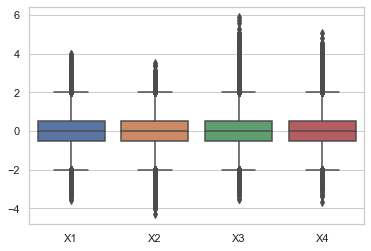

In [148]:
### scale 다르고, outlier 존재함
sns.boxplot(data=train_data.loc[:, var_list])
plt.show()

In [149]:
### 거의 좌우 대칭. 변환은 딱히 필요하지 않을 듯.
for var in var_list:
    print('Skew', var, ':', train_data[var].skew())

Skew X1 : 0.08555714728999815
Skew X2 : -0.14239912239051758
Skew X3 : 0.39500029300978495
Skew X4 : 0.24201522411624377


In [150]:
### 각 기계별로 scaling 필요. 기계가 다르면 센서도 달라진다.
# 기계 단위로 split 한 다음 다시 merge.
# Outlier가 있으므로 RobustScaler 적용.
scaled_train_data = pd.DataFrame()
scaled_valid_data = pd.DataFrame()
for m_id in train_data.M_ID.unique():
    tmp_train_data = train_data[train_data.M_ID==m_id]
    tmp_valid_data = valid_data[valid_data.M_ID==m_id]
    
    scaler = RobustScaler()
    train_s = scaler.fit_transform(tmp_train_data.loc[:, var_list])
    val_s = scaler.transform(tmp_valid_data.loc[:, var_list])
    
    scaled_train_data = pd.concat([scaled_train_data, pd.DataFrame(train_s, columns=var_list)])
    scaled_valid_data = pd.concat([scaled_valid_data, pd.DataFrame(val_s, columns=var_list)])

In [151]:
scaled_train_data.reset_index(inplace=True, drop=True)
scaled_valid_data.reset_index(inplace=True, drop=True)

In [152]:
for var in var_list:
    train_data[var] = scaled_train_data[var]
    valid_data[var] = scaled_valid_data[var]

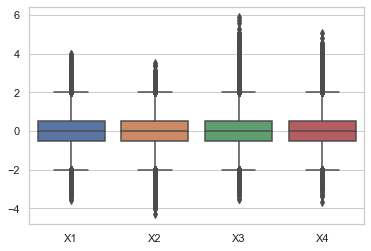

In [153]:
### scale 완료
sns.boxplot(data=train_data.loc[:, var_list])
plt.show()

In [154]:
### New measures data 생성
measure_data = pd.concat([train_data, valid_data])
measure_data['Date'] = pd.to_datetime(measure_data['Date'])

In [155]:
measure_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876100 entries, 0 to 75099
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                876100 non-null  datetime64[ns]
 1   M_ID                    876100 non-null  int64         
 2   X1                      876100 non-null  float64       
 3   X2                      876100 non-null  float64       
 4   X3                      876100 non-null  float64       
 5   X4                      876100 non-null  float64       
 6   Type                    876100 non-null  int64         
 7   Age                     876100 non-null  int64         
 8   maint_C02               876100 non-null  int64         
 9   maint_C04               876100 non-null  int64         
 10  maint_C03               876100 non-null  int64         
 11  maint_C01               876100 non-null  int64         
 12  error_E01               876100 

In [156]:
# temp save
measure_data.to_csv('./data/machine_merged.csv', index=False)

In [57]:
measure_data = pd.read_csv('./data/machine_merged.csv')

### Error, Maint, Fail

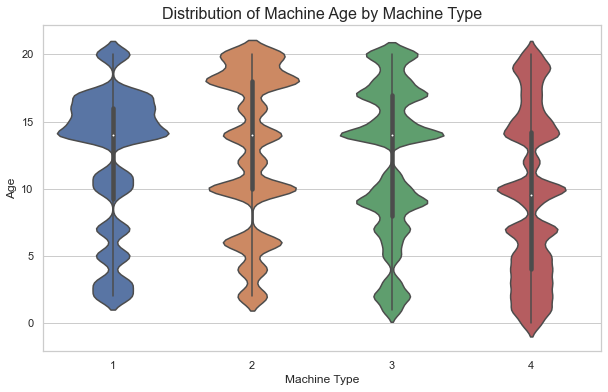

In [71]:
# 기계 연식 시각화
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.violinplot(x="Type", y="Age", data=train_data)

# Set the title and labels
plt.title("Distribution of Machine Age by Machine Type", fontsize=16)
plt.xlabel("Machine Type", fontsize=12)
plt.ylabel("Age", fontsize=12)

# Show the plot
plt.show()

In [72]:
### 연식이 높을 수록 fail_C03과 fail_C04의 발생이 커지는 경향이 있음
correlation_age_failures_types = {}

for fail_type in fail_cols:
    grouped_data_failures_type = train_data.groupby(['M_ID', 'Age'])[fail_type].sum().reset_index()
    correlation_age_failures_types[fail_type] = grouped_data_failures_type['Age'].corr(grouped_data_failures_type[fail_type])

correlation_age_failures_types

{'fail_C01': -0.05952399217143976,
 'fail_C02': -0.024346885417601643,
 'fail_C03': 0.12234419714260929,
 'fail_C04': 0.8081871085363157}

<AxesSubplot:>

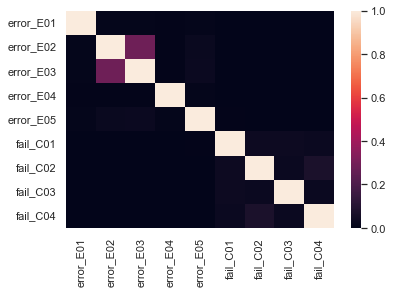

In [73]:
# error와 fail의 상관관계
# error 2와 3이 상관관계가 있고, 나머지는 상관관계가 없음
sns.heatmap(train_data.loc[:, error_cols + fail_cols].corr())

<AxesSubplot:>

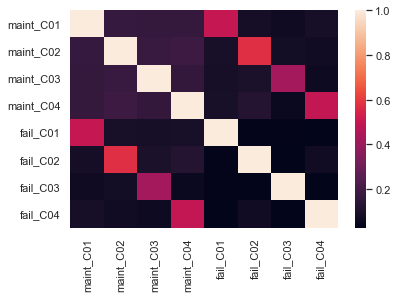

In [74]:
# maint와 fail의 상관관계
# 각 component 별로 0.4~0.6 정도의 상관관계 있음 확인
# fail -> mnt 관계가 있기 때문
sns.heatmap(train_data.loc[:, maint_cols + fail_cols].corr())

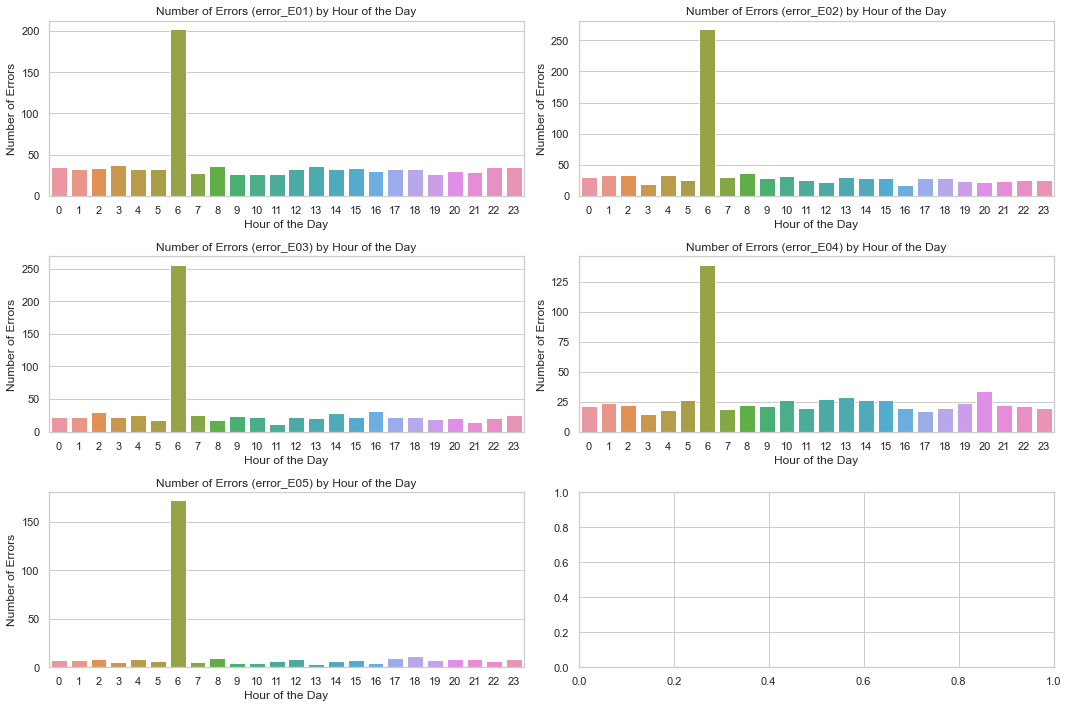

In [75]:
# 시간대 별 error 시각화
# Calculate the number of errors for each hour of the day and each type of error
train_data['hour_of_day'] = pd.to_datetime(train_data['DateTime']).dt.hour
errors_by_hour_of_day_and_type = train_data.groupby('hour_of_day')[error_cols].sum()

# Create a bar plot for each type of error
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for i, error_col in enumerate(error_cols):
    ax = axes[i]
    sns.barplot(x=errors_by_hour_of_day_and_type.index, y=errors_by_hour_of_day_and_type[error_col], ax=ax)
    ax.set_xlabel('Hour of the Day')
    ax.set_ylabel('Number of Errors')
    ax.set_title('Number of Errors (' + error_col + ') by Hour of the Day')
plt.tight_layout()
plt.show()

# error는 6시에 많이 발생한다. why?
# fail의 경우 무조건 6시에만 발생(하도록 데이터 변경)함

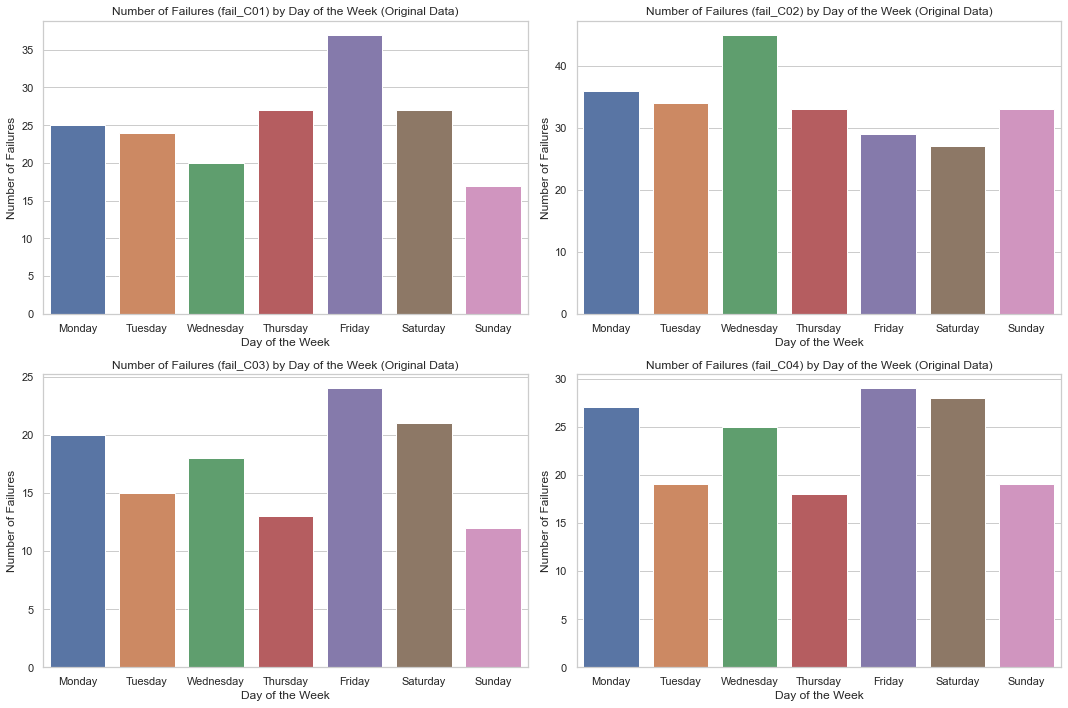

In [76]:
# 요일 별 fail 발생 횟수
# 유의미한 결과를 찾기는 어려웠음
# Calculate the number of failures for each day of the week and each type of failurek
train_data['day_of_week'] = pd.to_datetime(train_data['DateTime']).dt.dayofweek
failures_by_day_of_week_and_type_original = train_data.groupby('day_of_week')[fail_cols].sum()

# Create a bar plot for each type of failure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for i, fail_col in enumerate(fail_cols):
    ax = axes[i]
    sns.barplot(x=failures_by_day_of_week_and_type_original.index, y=failures_by_day_of_week_and_type_original[fail_col], ax=ax)
    ax.set_xlabel('Day of the Week')
    ax.set_ylabel('Number of Failures')
    ax.set_title('Number of Failures (' + fail_col + ') by Day of the Week (Original Data)')
    ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.tight_layout()
plt.show()

In [77]:
from scipy.stats import chi2_contingency

# 요일 별 발생횟수의 차이 검정 -> 귀무가설 기각되지 않음
# Create a contingency table for failures by day of the week
train_data['Day'] = train_data['DateTime'].dt.dayofweek
train_data['Total_Fails'] = train_data[fail_cols].sum(axis=1)
contingency_table = pd.crosstab(train_data['Day'], train_data['Total_Fails'] > 0)

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2, p

(7.196188497992976, 0.3030844155559602)

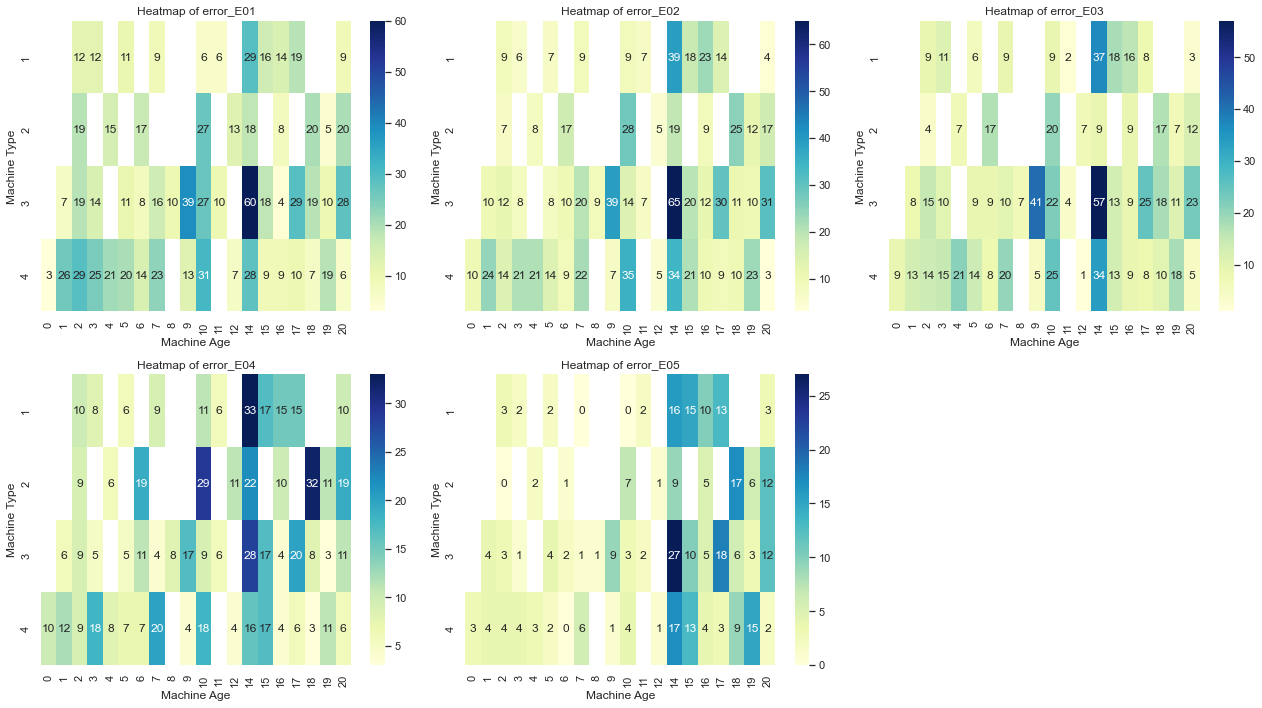

In [78]:
# 연식, 타입 별 error 발생 횟수
# Create a heatmap for each type of error with swapped axes
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, error_col in enumerate(error_cols):
    ax = axes[i]
    errors_by_type_and_age = train_data.groupby(['Type', 'Age'])[error_cols].sum().reset_index()
    pivot_table = errors_by_type_and_age.pivot(index='Type', columns='Age', values=error_col)
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".0f", ax=ax)
    ax.set_xlabel('Machine Age')
    ax.set_ylabel('Machine Type')
    ax.set_title('Heatmap of ' + error_col)

# Remove the last subplot as it is not used
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

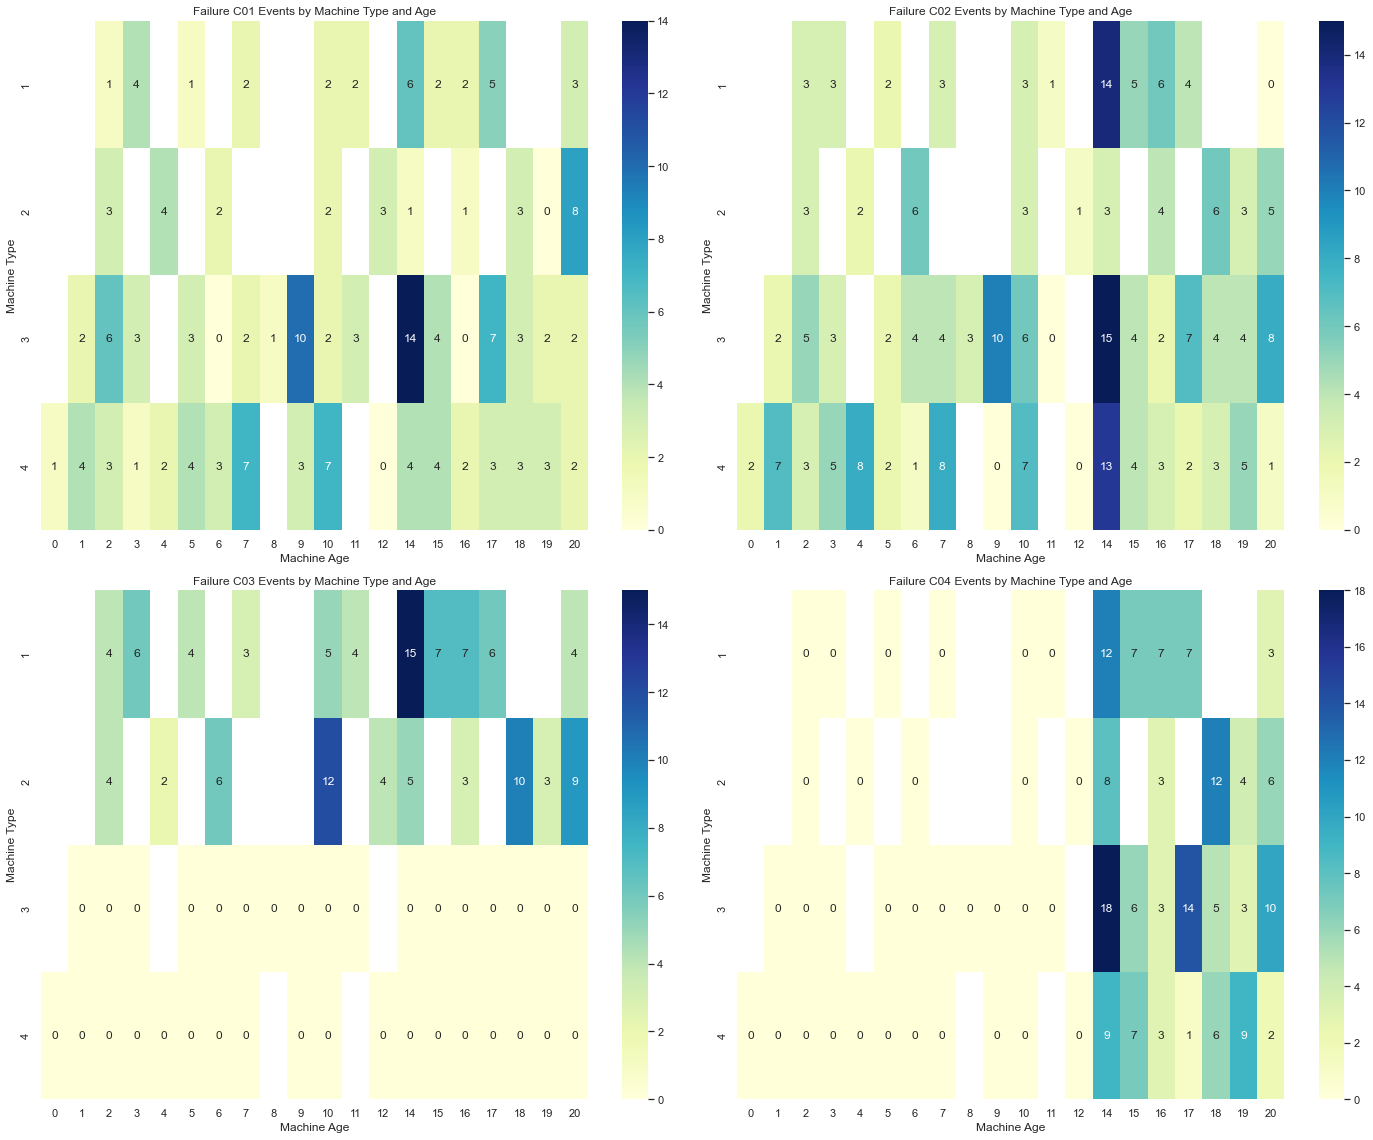

In [79]:
# 연식, 타입 별 fail 발생 횟수
# Group the data by Machine Type and Age, and calculate the sum of each failure type for each group
grouped_data_fail_C01 = train_data.groupby(['Type', 'Age'])['fail_C01'].sum().reset_index()
grouped_data_fail_C02 = train_data.groupby(['Type', 'Age'])['fail_C02'].sum().reset_index()
grouped_data_fail_C03 = train_data.groupby(['Type', 'Age'])['fail_C03'].sum().reset_index()
grouped_data_fail_C04 = train_data.groupby(['Type', 'Age'])['fail_C04'].sum().reset_index()

# Create pivot tables for the heatmaps
pivot_table_fail_C01 = grouped_data_fail_C01.pivot('Type', 'Age', 'fail_C01')
pivot_table_fail_C02 = grouped_data_fail_C02.pivot('Type', 'Age', 'fail_C02')
pivot_table_fail_C03 = grouped_data_fail_C03.pivot('Type', 'Age', 'fail_C03')
pivot_table_fail_C04 = grouped_data_fail_C04.pivot('Type', 'Age', 'fail_C04')

# Generate heatmaps
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

sns.heatmap(pivot_table_fail_C01, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[0, 0])
axes[0, 0].set_title('Failure C01 Events by Machine Type and Age')
axes[0, 0].set_xlabel('Machine Age')
axes[0, 0].set_ylabel('Machine Type')

sns.heatmap(pivot_table_fail_C02, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Failure C02 Events by Machine Type and Age')
axes[0, 1].set_xlabel('Machine Age')
axes[0, 1].set_ylabel('Machine Type')

sns.heatmap(pivot_table_fail_C03, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[1, 0])
axes[1, 0].set_title('Failure C03 Events by Machine Type and Age')
axes[1, 0].set_xlabel('Machine Age')
axes[1, 0].set_ylabel('Machine Type')

sns.heatmap(pivot_table_fail_C04, annot=True, fmt=".0f", cmap='YlGnBu', ax=axes[1, 1])
axes[1, 1].set_title('Failure C04 Events by Machine Type and Age')
axes[1, 1].set_xlabel('Machine Age')
axes[1, 1].set_ylabel('Machine Type')

plt.tight_layout()
plt.show()

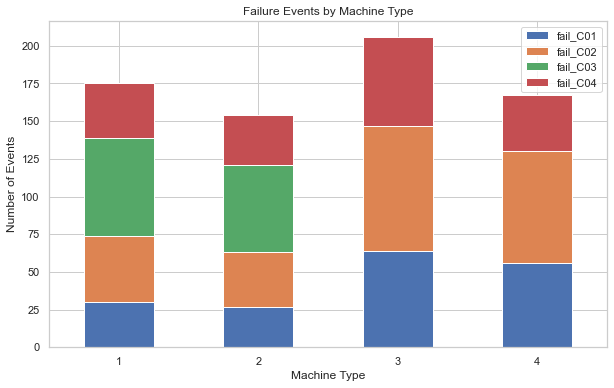

In [80]:
# 다른 시각화: 기계 종류 별 고장의 유형
# 기계 종류 3, 4는 3번 component fail이 발생하지 않음
# Group the data by Machine Type, and calculate the sum of each failure type for each group
grouped_data_fail = train_data.groupby('Type')[fail_cols].sum()

# Generate a bar plot
grouped_data_fail.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Failure Events by Machine Type')
plt.xlabel('Machine Type')
plt.ylabel('Number of Events')
plt.xticks(rotation=0)
plt.show()

In [81]:
### error와 다음 날 fail의 발생 빈도
total_fails = train_data[fail_cols].sum()

# Initialize a dictionary to store results
fail_after_specific_error = {}

# Loop through each error column
for error in error_cols:
    # Shift the error column to get errors from the previous day
    train_data['Specific_Error_Previous_Day'] = train_data.groupby('M_ID')[error].shift()

    # Count failures that occurred after a specific error
    fail_after_specific_error[error] = (train_data[train_data['Specific_Error_Previous_Day'] == 1][fail_cols].sum() / total_fails) * 100

fail_after_specific_error = pd.DataFrame(fail_after_specific_error).T
fail_after_specific_error

,fail_C01,fail_C02,fail_C03,fail_C04
error_E01,0.000000,0.0,0.813008,0.0
error_E02,0.000000,0.0,0.000000,0.0
error_E03,0.000000,0.0,0.000000,0.0
error_E04,0.564972,0.0,0.000000,0.0
error_E05,0.000000,0.0,0.813008,0.0


## Data 집계 for all data

### Outlier 관련 변수 추가

In [82]:
from scipy.stats import iqr

In [83]:
# For each maintenance and failure type
for maint_c, fail_c in zip(maint_cols, fail_cols):
    # Create new columns to store whether the maintenance was due to a failure
    measure_data[maint_c + '_and_' + fail_c] = (measure_data[maint_c] > 0) & (measure_data[fail_c] > 0)
    
# Convert the boolean values to integers (1 for True, 0 for False)
for col in measure_data.columns:
    if '_and_' in col:
        measure_data[col] = measure_data[col].astype(int)

In [84]:
# Function to detect outliers based on IQR
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = iqr(df[feature])
    
    # Define outliers
    lower_outliers = df[feature] < Q1 - 1.5 * IQR
    upper_outliers = df[feature] > Q3 + 1.5 * IQR
    
    return lower_outliers, upper_outliers

# outlier 개수 넣기
for feature in var_list:
    lower_outliers, upper_outliers = detect_outliers(measure_data, feature)
    measure_data[f'lower_outlier_{feature}'] = lower_outliers
    measure_data[f'upper_outlier_{feature}'] = upper_outliers

In [85]:
outlier_cols = [f'{j}_outlier_{i}' for i in var_list for j in ['lower', 'upper']]

### Aggregation, shift

In [86]:
### data 변형과 shift
agg_sum_data = measure_data.loc[:, ['M_ID', 'Date'] + maint_cols + error_cols + fail_cols + outlier_cols].groupby('M_ID').resample(rule='D', on='Date').sum()
agg_sum_data['M_ID'] = agg_sum_data.index.get_level_values(0)
agg_sum_data = agg_sum_data.droplevel(0)
agg_sum_data.reset_index(inplace=True)

x_agg_data = pd.DataFrame()
for agg_type in ['mean', 'median', 'min', 'max', 'std']:
    agg_data = measure_data.loc[:, ['M_ID', 'Date'] + var_list].groupby('M_ID').resample(rule='D', on='Date').mean()
    agg_data['M_ID'] = agg_data.index.get_level_values(0)
    agg_data = agg_data.droplevel(0)
    agg_data.reset_index(inplace=True)
    agg_data.columns = ['Date', 'M_ID'] + [f'{i}_{agg_type}' for i in var_list]
    
    if len(x_agg_data)==0:
        x_agg_data = agg_data
    else:
        x_agg_data = pd.merge(x_agg_data, agg_data, how='inner', on=['Date', 'M_ID'])

agg_data = pd.merge(agg_sum_data, x_agg_data, how='inner', on=['Date', 'M_ID'])

In [87]:
agg_data['NextDay'] = agg_data['Date'].dt.date + pd.DateOffset(days=1)
agg_data.drop('NextDay', axis=1, inplace=True)

# 고장 컬럼 shift
# Converting DateTime from string to datetime format
for col in fail_cols:
    agg_data[col] = agg_data.groupby('M_ID')[col].shift(-1)
agg_data.dropna(inplace=True)

# Calculate Q1 and Q3 for each X variable for each date and machine
quantiles = measure_data.groupby(['Date', 'M_ID'])[var_list].quantile([0.25, 0.75]).unstack(level=2)

# Flatten the column names
quantiles.columns = ['_'.join([str(el) for el in col]) for col in quantiles.columns.values]

# Merge the quantiles with the aggregated data
agg_data = pd.merge(agg_data, quantiles, how='left', left_on=['Date', 'M_ID'], right_index=True)

### 변수 추가

In [88]:
# Type 변수 agg_data에 추가
def get_type(m_id):
    return measure_data.loc[(measure_data.Date=='2015-01-01') | (measure_data.M_ID==m_id), 'Type'].values[0]

agg_data['Type'] = agg_data['M_ID'].apply(get_type)

In [64]:
# Age 변수 agg_data에 추가
def get_age(m_id):
    return measure_data.loc[(measure_data.Date=='2015-01-01') | (measure_data.M_ID==m_id), 'Age'].values[0]

agg_data['Age'] = agg_data['M_ID'].apply(get_age)

In [91]:
# Function to calculate the number of days since the most recent maintenance
def days_since_most_recent_maint_or_fail(df, maint_column):
    maint_or_fail = df[maint_column.replace('maint', 'fail')].astype(int) | df[maint_column].astype(int)

    # Find where maintenance has occurred
    maint_days = maint_or_fail == 1

    # Calculate the number of days since the most recent maintenance

    days_since = maint_days.groupby((maint_days != maint_days.shift()).cumsum()).cumcount()

    # Reverse the results to match the original DataFrame
    days_since = days_since[::-1]

    return days_since

# Apply the function to each maintenance column
for col in maint_cols:
    agg_data[f'days_since_last_{col}'] = days_since_most_recent_maint_or_fail(agg_data, col)

# Check the new columns
agg_data.head()

,Date,M_ID,maint_C01,maint_C02,maint_C03,maint_C04,error_E01,error_E02,error_E03,error_E04,...,X2_0.75,X3_0.25,X3_0.75,X4_0.25,X4_0.75,Type,days_since_last_maint_C01,days_since_last_maint_C02,days_since_last_maint_C03,days_since_last_maint_C04
0,2015-01-01,1,0,0,0,0,0,0,0,0,...,0.523734,-0.500601,0.561451,-0.555463,0.404585,3,0,0,0,0
1,2015-01-02,1,0,0,0,0,0,0,0,0,...,0.575542,-0.632572,0.266788,-0.621073,0.361299,3,1,1,1,1
2,2015-01-03,1,0,0,0,0,1,0,1,0,...,0.614437,-0.625568,0.300306,0.408110,1.825924,3,2,2,2,2
3,2015-01-04,1,0,0,0,0,0,0,0,0,...,0.304894,-0.463807,0.808467,1.290855,2.323024,3,3,3,3,0
4,2015-01-05,1,1,0,0,1,0,0,0,0,...,0.662373,-0.345020,0.646665,-0.299876,1.113865,3,0,4,4,1


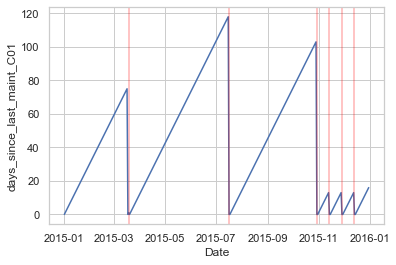

In [92]:
# column sample
sns.lineplot(y='days_since_last_maint_C01', x='Date', data=agg_data[agg_data['M_ID']==2])
for idx in (agg_data[agg_data['M_ID']==2][agg_data.maint_C01 > 0]['Date'].values):
    plt.axvline(idx, color='red', alpha=0.3)
plt.show()

### Some more EDAs

In [93]:
# Error의 경우 하루에 두 번 이상 발생한 경우가 존재함
count_check_columns = [col for col in agg_data.columns if 'error' in col or 'maint' in col or 'fail' in col]

# Check if any value is greater than 1
agg_data[count_check_columns].gt(1).sum()

maint_C01                        0
maint_C02                        0
maint_C03                        0
maint_C04                        0
error_E01                       15
error_E02                       14
error_E03                        8
error_E04                        8
error_E05                        2
fail_C01                         0
fail_C02                         0
fail_C03                         0
fail_C04                         0
days_since_last_maint_C01    34191
days_since_last_maint_C02    33950
days_since_last_maint_C03    34243
days_since_last_maint_C04    34187
dtype: int64

In [94]:
### 연속으로 fail이 발생한 경우는 없음
# Create a new dataframe to store the results
continuous_failures = pd.DataFrame()

# For each machine
for machine in agg_data['M_ID'].unique():
    # For each type of failure
    for fail_c in fail_cols:
        # Get the dates when failures occurred
        fail_dates = agg_data.loc[(agg_data['M_ID'] == machine) & (agg_data[fail_c] > 0), 'Date'].sort_values()
        # Calculate the differences between consecutive failure dates
        fail_diffs = fail_dates.diff().dt.days
        # If there are any differences of 1 day (i.e., continuous failures)
        if any(fail_diffs == 1):
            # Add a row to the results dataframe
            continuous_failures = continuous_failures.append({'Machine': machine, 'Failure': fail_c, 'Continuous Failures': True}, ignore_index=True)

# Display the results
continuous_failures

""


### Aggregated data 저장/로드

In [68]:
# agg_data.to_csv('./data/machine_agg.csv', index=False)

In [69]:
agg_data = pd.read_csv('./data/machine_agg.csv')

In [70]:
# 발생 여부를 나타내는 컬럼은 category로 변경
# Identify the maintenance and failure columns
# error column은 발생 여부가 아니라 발생 횟수를 나타냄
maint_columns = [col for col in agg_data.columns if 'maint' in col if not 'days_since' in col]
fail_columns = [col for col in agg_data.columns if 'fail' in col]

# Change these columns to category type
for col in maint_columns + fail_columns:
    agg_data[col] = agg_data[col].astype('category')
    
# M_ID와 Type도 category로 변경
agg_data['M_ID'] = agg_data['M_ID'].astype('category')
agg_data['Type'] = agg_data['Type'].astype('category')

# Check the data types to confirm
agg_data[maint_columns + fail_columns].dtypes

maint_C01    category
maint_C02    category
maint_C03    category
maint_C04    category
fail_C01     category
fail_C02     category
fail_C03     category
fail_C04     category
dtype: object

In [71]:
# 날짜 컬럼 변경
agg_data['Date'] = pd.to_datetime(agg_data['Date'])

In [72]:
agg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36500 entries, 0 to 36499
Data columns (total 57 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       36500 non-null  datetime64[ns]
 1   M_ID                       36500 non-null  category      
 2   maint_C01                  36500 non-null  category      
 3   maint_C02                  36500 non-null  category      
 4   maint_C03                  36500 non-null  category      
 5   maint_C04                  36500 non-null  category      
 6   error_E01                  36500 non-null  int64         
 7   error_E02                  36500 non-null  int64         
 8   error_E03                  36500 non-null  int64         
 9   error_E04                  36500 non-null  int64         
 10  error_E05                  36500 non-null  int64         
 11  fail_C01                   36500 non-null  category      
 12  fail

### Data split

In [73]:
train_data = agg_data[agg_data.Date < '2015-12-01']
valid_data = agg_data[agg_data.Date >= '2015-12-01']

## Model train

In [4]:
import matplotlib.dates as mdates

from itertools import product
from tqdm import tqdm

from sklearn.metrics import *
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Conv1D, Conv1DTranspose
from keras.backend import clear_session
from keras.optimizers import Adam

2023-08-21 12:39:13.398375: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Baseline cost

In [15]:
### Valid data의 Baseline 비용 계산
# 고장에 의한 손실 비용 계산
# fail_loss = 100 * (valid_data.loc[:, fail_cols].sum(axis=1).value_counts()[1:].sum()) # 동시에 일어난 고장은 한 번만 처리하는 경우
fail_loss = 100 * (valid_data.loc[:, fail_cols].astype(int).sum().sum()) # 각 컴포넌트 고장마다 비용 처리
print('고장에 의한 비용:', fail_loss)

# 컴포넌트 교체 비용 계산
comp_cost = [15, 30, 20, 25]
# 정기 교체 비용. 고장에 의한 교체와 동시에 일어난 경우 한 번만 발생한 것으로 생각해야 함
maint_comp_cost_sum = 0
for i, col in enumerate(comp_list):
    maint_comp_cost_sum += (valid_data.loc[:, 'maint_' + col].astype(int) | valid_data.loc[:, 'fail_' + col].astype(int)).sum() * comp_cost[i]
    
print('컴포넌트 교체 비용:', maint_comp_cost_sum)

base_cost = fail_loss + maint_comp_cost_sum

고장에 의한 비용: 5700
컴포넌트 교체 비용: 6890


In [38]:
fail_comp_cost_sum = 0
for i, col in enumerate(comp_list):
    fail_comp_cost_sum += valid_data.loc[:, 'fail_' + col].astype(int).sum() * comp_cost[i]
print('maint 없이 고장난 컴포넌트만 교체할 때 비용:', fail_comp_cost_sum)

base_cost_2 = fail_loss + fail_comp_cost_sum

maint 없이 고장난 컴포넌트만 교체할 때 비용: 1345


In [16]:
### 각 컴포넌트 별 
### 고장으로 예상된 경우 정기 교체 진행 -> 교체 비용 발생
### 고장으로 예상되지 않았으나 고장이 난 경우, 고장 비용 + 교체 비용 발생
cost_matrix = [[[0, 0, 0, 0], comp_cost], [[100 + i for i in comp_cost], comp_cost]]

In [48]:
### Split by timestamp
def get_sub_df(data):
    sub_df_list = list()

    # time diff 계산
    diff_time = data['Date'] - data['Date'].shift(1)

    # time diff가 1시간 이상인 index 추출
    big_diff_list = [i for i in diff_time.index if diff_time[i] > convert_string_to_timedelta('24:00:00')]

    # time diff index를 바탕으로 sub-dataframe 추출
    if len(big_diff_list)==0:
        sub_df_list.append(data)
    else:
        for i, diff_index in enumerate(big_diff_list):                
            if i==0:
                sub_df_list.append(data.loc[:diff_index-1])
            else:
                sub_df_list.append(data.loc[big_diff_list[i-1]:diff_index-1])
                if i==len(big_diff_list)-1:
                    sub_df_list.append(data.loc[diff_index:])
                        
    return sub_df_list

def get_recon_err(x, x_pred, y):
    di = x.shape
    if len(di) < 3 :
        mse = np.mean(np.power(x - x_pred, 2), axis=1) # 2차원 데이터
    else :
        mse = np.mean(np.power(x.reshape(x.shape[0], -1) - x_pred.reshape(x_pred.shape[0], -1), 2), axis=1) # 3차원 데이터

    error_df = pd.DataFrame({'Recon_error': mse, 'True_class': y})
    error_df = error_df.reset_index(drop=True)
    
    return error_df

def recon_err_plot(error_df, threshold=0):
    groups = error_df.groupby('True_class')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.Recon_error, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for different classes")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

def prec_rec_f1_curve(y, score, pos_label=1) :
    # precision, recall, f1 계산
    precision, recall, thresholds = precision_recall_curve(y, score, pos_label=pos_label)
    f1 = 2 / (1/precision + 1/recall)

    # 그래프 그리기
    plt.figure(figsize = (10,6))
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')

    #-------------------------------------------------------------------------
    # 아래 코드는 차트 꾸미기 입니다. 
    # f1를 최대화 해주는 threshold
    thre = round(thresholds[np.argmax(f1)],4)
    f1s = round(max(f1),4)
    plt.axvline(thre , color = 'darkred', linewidth = .7)
    plt.axhline(f1s, color = 'darkred', linewidth = .7)
    plt.text(thre, .5, thre, color = 'darkred')
    plt.text(min(thresholds), f1s, f1s, color = 'darkred')

    plt.xlabel('Anomaly Score')
    plt.ylabel('Performance')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

def get_confusion_matrix(y, pred, thresholds):
    return confusion_matrix(y, np.where(pred > thresholds, 1, 0))

def classification_report_with_cm(y, pred, thresholds):
    pred_temp = np.where(pred > thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')
    print('< classification_report >\n')
    print(classification_report(y, pred_temp))
    
    return cm

def calculate_cost(y, pred, thresholds, comp_num):
    pred_temp = np.where(pred > thresholds, 1, 0)
    cost_matrix_comp = [[cost_matrix[0][0][comp_num-1], cost_matrix[0][1][comp_num-1]],
                        [cost_matrix[1][0][comp_num-1], cost_matrix[1][1][comp_num-1]]]
    return (confusion_matrix(y, pred_temp) * cost_matrix_comp).sum()

def cost_curve(y_val, val_score, thresholds, comp_num):
    cost_list = list()
    for thre in thresholds:
        cost_list.append(calculate_cost(y_val, val_score, thre, comp_num))

    cost_list = np.array(cost_list)

    # 그래프 그리기
    plt.figure(figsize = (10,6))
    plt.plot(thresholds, cost_list, label='cost')

    #-------------------------------------------------------------------------
    # 아래 코드는 차트 꾸미기 입니다. 
    thre = round(thresholds[np.argmin(cost_list)], 4)
    cost = round(min(cost_list), 4)
    plt.axvline(thre , color = 'darkred', linewidth = .7)
    plt.axhline(cost, color = 'darkred', linewidth = .7)

    plt.xlabel('Anomaly Score')
    plt.ylabel('Cost')
    plt.legend()
    plt.grid()
    plt.show()
    
    return thre, cost

In [18]:
train_data.head()

,Date,M_ID,maint_C01,maint_C02,maint_C03,maint_C04,error_E01,error_E02,error_E03,error_E04,...,X2_0.75,X3_0.25,X3_0.75,X4_0.25,X4_0.75,Type,days_since_last_maint_C01,days_since_last_maint_C02,days_since_last_maint_C03,days_since_last_maint_C04
0,2015-01-01,1,0,0,0,0,0,0,0,0,...,0.523734,-0.500601,0.561451,-0.555463,0.404585,3,0,0,0,0
1,2015-01-02,1,0,0,0,0,0,0,0,0,...,0.575542,-0.632572,0.266788,-0.621073,0.361299,3,1,1,1,1
2,2015-01-03,1,0,0,0,0,1,0,1,0,...,0.614437,-0.625568,0.300306,0.408110,1.825924,3,2,2,2,2
3,2015-01-04,1,0,0,0,0,0,0,0,0,...,0.304894,-0.463807,0.808467,1.290855,2.323024,3,3,3,3,0
4,2015-01-05,1,1,0,0,1,0,0,0,0,...,0.662373,-0.345020,0.646665,-0.299876,1.113865,3,0,4,4,1


### Data prepare for ML

In [74]:
### Model input으로 쓰지 않을 columns
except_cols = ['M_ID', 'Date']

In [75]:
# extract y from data
x_train = train_data.drop(fail_cols, axis=1)
x_val = valid_data.drop(fail_cols, axis=1)

y_train = train_data.loc[:, fail_cols]
y_val = valid_data.loc[:, fail_cols]

In [76]:
x_train_cleaned = x_train.drop(except_cols, axis=1)
x_val_cleaned = x_val.drop(except_cols, axis=1)

### Isolation Forest

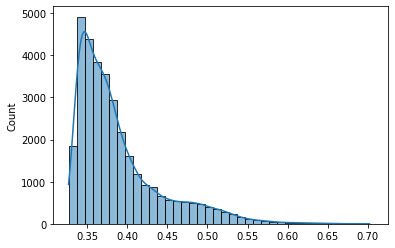

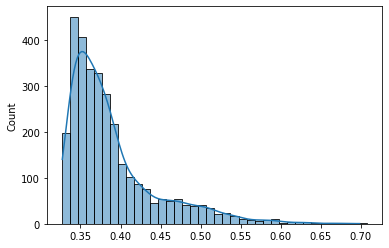

In [77]:
# train와 valid의 분포에 큰 차이는 없음
model1 = IsolationForest()
model1.fit(x_train_cleaned)
pred1 = model1.predict(x_train_cleaned)
pred1 = np.where(pred1 == 1, 0, 1)

train_score = model1.score_samples(x_train_cleaned)
train_score = -1 * train_score 

val_score = model1.score_samples(x_val_cleaned)
val_score = -1 * val_score

sns.histplot(train_score, kde=True, binwidth=0.01)
plt.show()

sns.histplot(val_score, kde=True, binwidth=0.01)
plt.show()

<Result for X1>


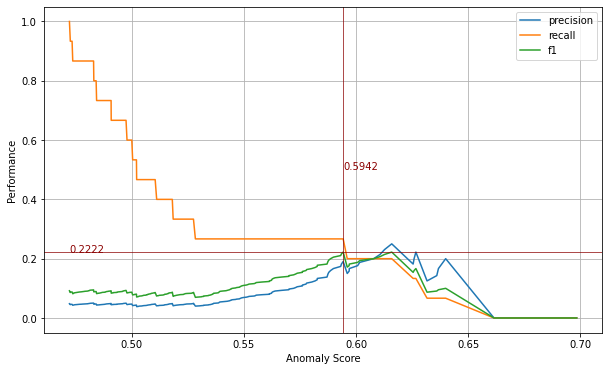

100%|███████████████████████████████████| 100/100 [05:30<00:00,  3.31s/it]


(20, 900)
0.26315789473684204


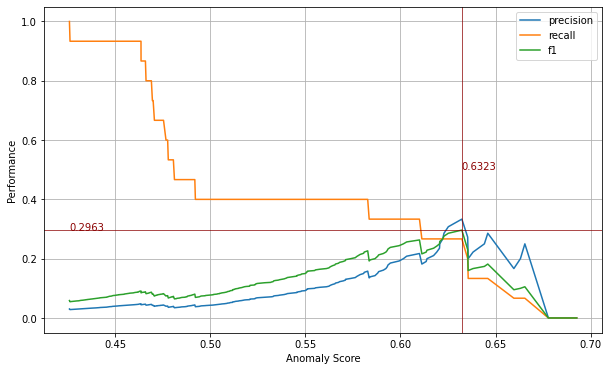

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3085
         1.0       0.33      0.27      0.30        15

    accuracy                           0.99      3100
   macro avg       0.66      0.63      0.65      3100
weighted avg       0.99      0.99      0.99      3100

[[3077    8]
 [  11    4]]

<Result for X2>


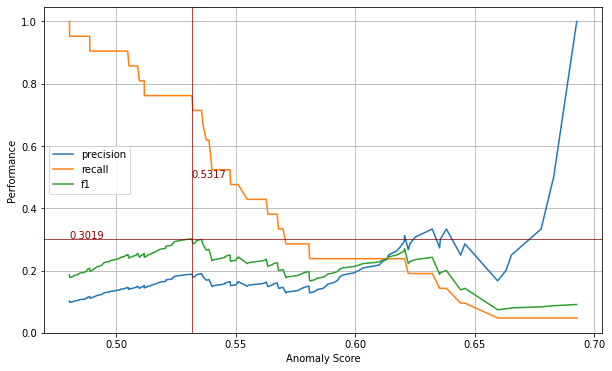

100%|███████████████████████████████████| 100/100 [05:37<00:00,  3.37s/it]


(120, 500)
0.36363636363636365


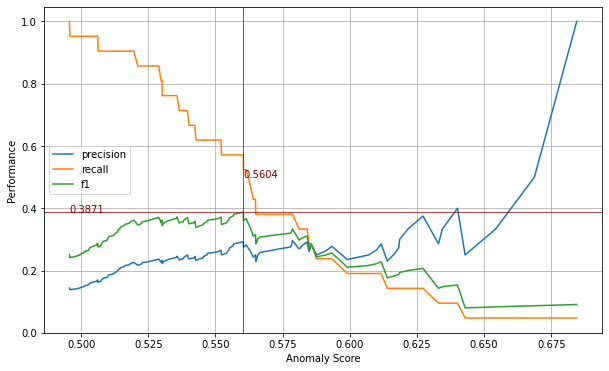

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3079
         1.0       0.29      0.57      0.39        21

    accuracy                           0.99      3100
   macro avg       0.64      0.78      0.69      3100
weighted avg       0.99      0.99      0.99      3100

[[3050   29]
 [   9   12]]

<Result for X3>


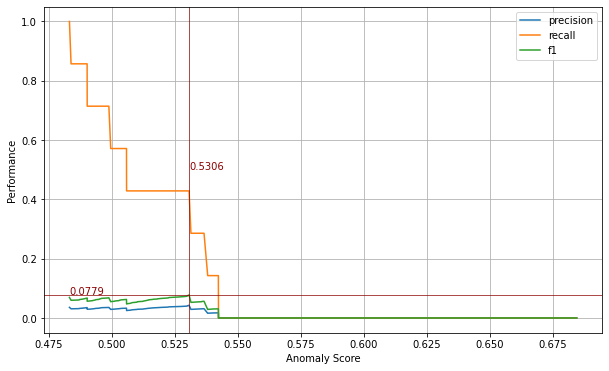

100%|███████████████████████████████████| 100/100 [05:50<00:00,  3.50s/it]


(40, 600)
0.12048192771084337


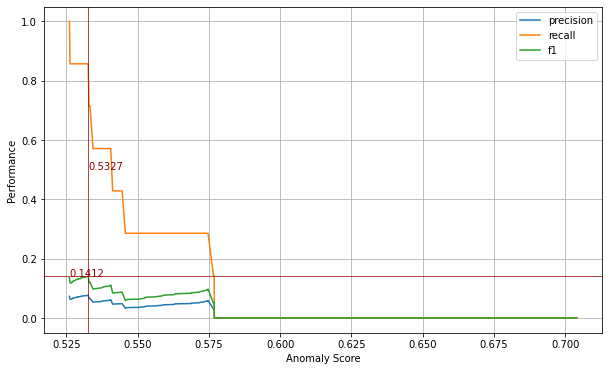

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      3093
         1.0       0.08      0.86      0.14         7

    accuracy                           0.98      3100
   macro avg       0.54      0.92      0.56      3100
weighted avg       1.00      0.98      0.99      3100

[[3021   72]
 [   1    6]]

<Result for X4>


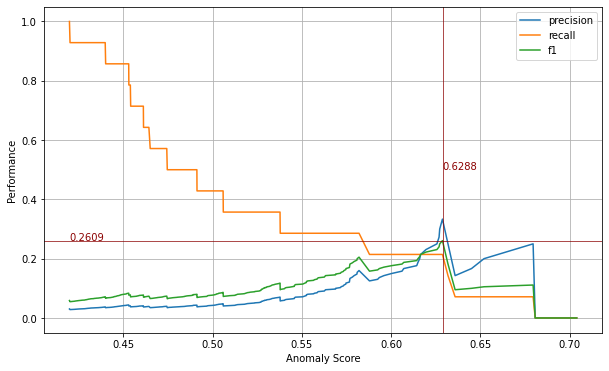

100%|███████████████████████████████████| 100/100 [05:34<00:00,  3.35s/it]


(200, 400)
0.2857142857142857


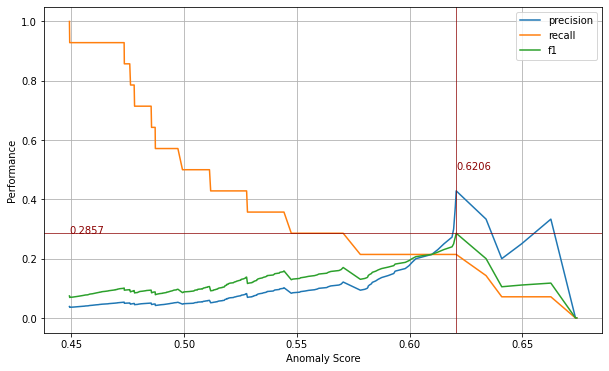

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3086
         1.0       0.43      0.21      0.29        14

    accuracy                           1.00      3100
   macro avg       0.71      0.61      0.64      3100
weighted avg       0.99      1.00      0.99      3100

[[3082    4]
 [  11    3]]



In [78]:
# y_train을 사용하지 않기 때문에, 모든 Component의 예측에 대해 동일한 결과 도출
# validation과 tuning 시 component 별로 나누어질 것으로 예상됨
isol_model_list = list()
for i in range(y_val.shape[1]):
    print(f'<Result for X{i+1}>')
    
    _, _, f1, thresholds = prec_rec_f1_curve(y_val.iloc[:, i], val_score)
    cutoff_f1max = thresholds[np.argmax(f1)]
    new_cont = sum(train_score >= cutoff_f1max) / len(train_score)
    
    n_est = list(range(20, 201, 20))
    max_s = list(range(100, 1001, 100))
    items = [n_est, max_s]
    params = list(product(*items))
    
    f1_list = []
    for p in tqdm(params) :
        model = IsolationForest(contamination=new_cont, n_estimators=p[0], max_samples=p[1], random_state=0)
        model.fit(x_train_cleaned)
        pred = model.predict(x_val_cleaned)
        pred = np.where(pred==1, 0, 1)
        f1_list.append(f1_score(y_val.iloc[:, i], pred, pos_label=1))
        
    max_id = np.argmax(f1_list)

    print(params[max_id])
    print(f1_list[max_id])
    
    model1 = IsolationForest(contamination=new_cont, n_estimators=params[max_id][0], max_samples=params[max_id][1], random_state=0)
    model1.fit(x_train_cleaned)

    pred1 = model1.predict(x_val_cleaned)
    pred1 = np.where(pred1==1, 0, 1)
    
    train_score = model1.score_samples(x_train_cleaned)
    train_score = -1 * train_score

    val_score = model1.score_samples(x_val_cleaned)
    val_score = -1 * val_score
    
    _, _, f1, thresholds = prec_rec_f1_curve(y_val.iloc[:, i], val_score)
    cutoff_f1max = thresholds[np.argmax(f1)]
    pred_y = np.where(val_score >= cutoff_f1max, 1, 0)
    cm = confusion_matrix(y_val.iloc[:, i], pred_y)
    print(classification_report(y_val.iloc[:, i], pred_y))
    print(cm)
    
    isol_model_list.append({"component": i+1, "model": model1, "f1_max": f1.max(), "cutoff": cutoff_f1max, "thresholds": thresholds,
                            "train_score": train_score, "val_score": val_score, "cm": cm})
    
    print('')

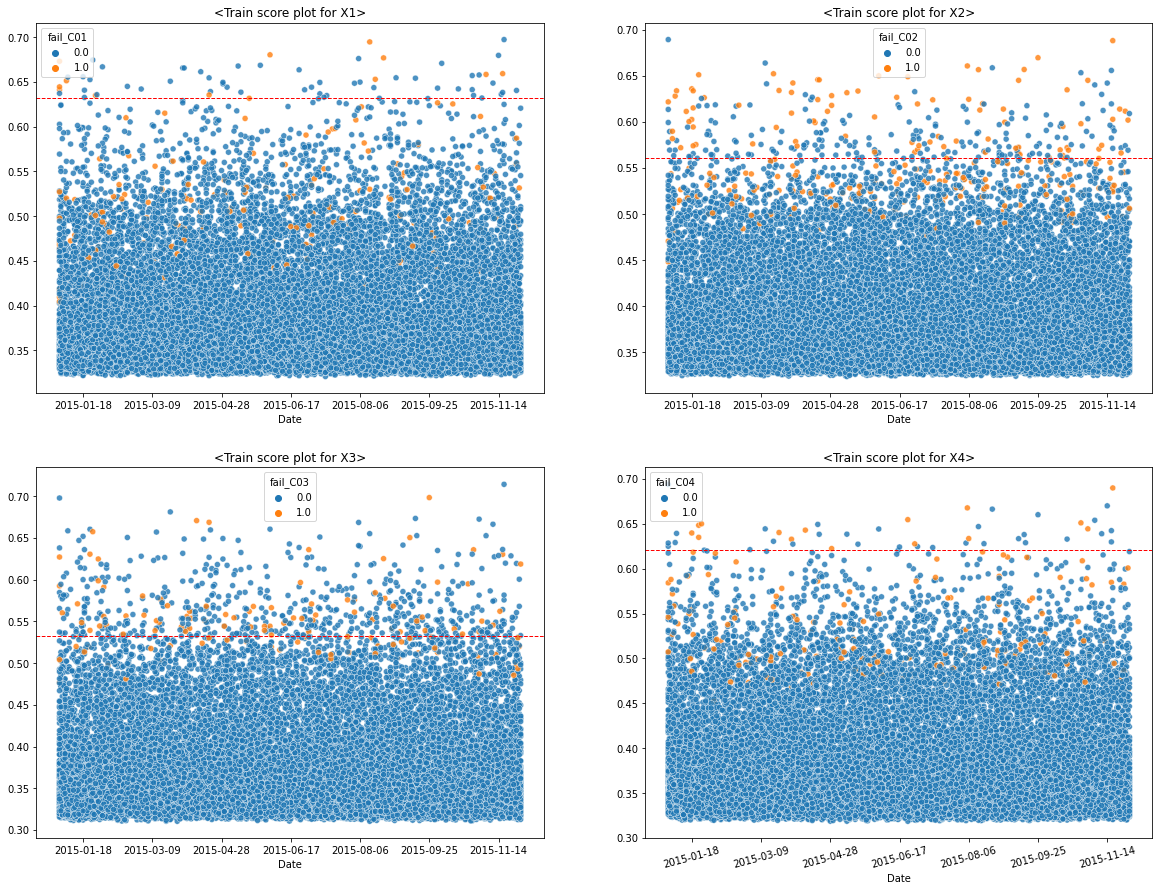

In [79]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))
for comp in isol_model_list:
    index_row = (comp['component']-1)//2
    index_col = (comp['component']-1)%2

    ax = axes[index_row][index_col]            
    plt.xticks(rotation=15)
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=50))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    ax.axhline(comp['cutoff'], color='red', linestyle='--', linewidth=1)
    ax.set_title(f"<Train score plot for X{comp['component']}>")
    sns.scatterplot(x=x_train['Date'], y=comp['train_score'], hue=y_train.iloc[:, comp['component']-1], ax=ax, alpha=0.8)

confusion matrix:
 [[3077    8]
 [  11    4]]
cutoff for minimum f1 score: 0.6323030412719192
confusion matrix:
 [[3050   29]
 [   9   12]]
cutoff for minimum f1 score: 0.5604163137248073
confusion matrix:
 [[3021   72]
 [   1    6]]
cutoff for minimum f1 score: 0.5326995155260743
confusion matrix:
 [[3082    4]
 [  11    3]]
cutoff for minimum f1 score: 0.6206471264845833


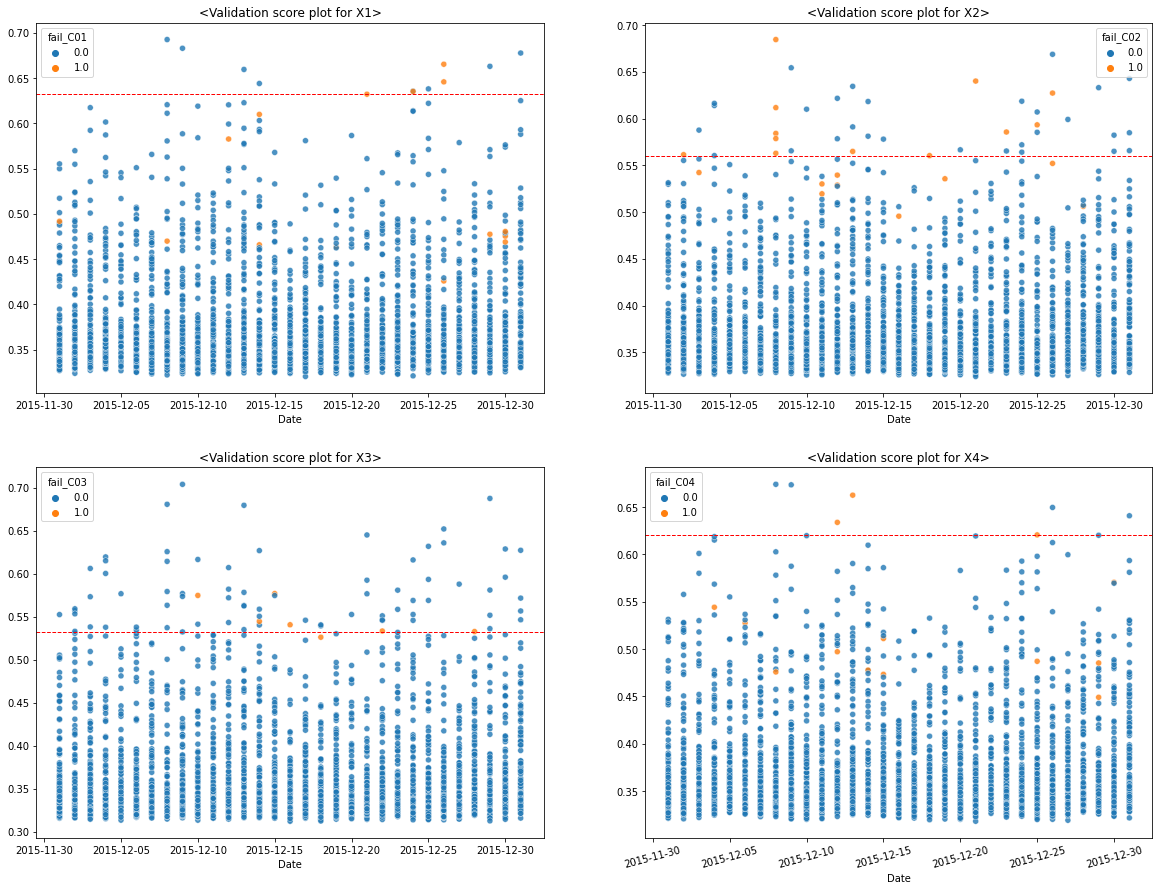

In [80]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))
for comp in isol_model_list:
    index_row = (comp['component']-1)//2
    index_col = (comp['component']-1)%2
    
    ax = axes[index_row][index_col]        
    plt.xticks(rotation=15)
    
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    ax.axhline(comp['cutoff'], color='red', linestyle='--', linewidth=1)
    ax.set_title(f"<Validation score plot for X{comp['component']}>")
    sns.scatterplot(x=x_val['Date'], y=comp['val_score'], hue=y_val.iloc[:, comp['component']-1], ax=ax, alpha=0.8)
    
    print('confusion matrix:\n', comp['cm'])
    print('cutoff for minimum f1 score:', comp['cutoff'])

Cost for component 1


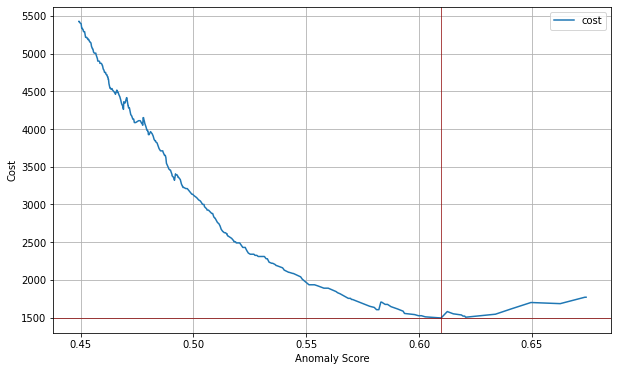

Component 1의 최소 비용 thresholds: 0.6098
Component 1의 최소 비용: 1495
Cost for component 2


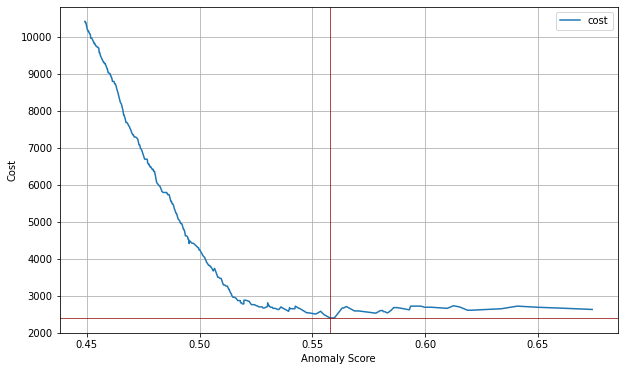

Component 2의 최소 비용 thresholds: 0.5578
Component 2의 최소 비용: 2400
Cost for component 3


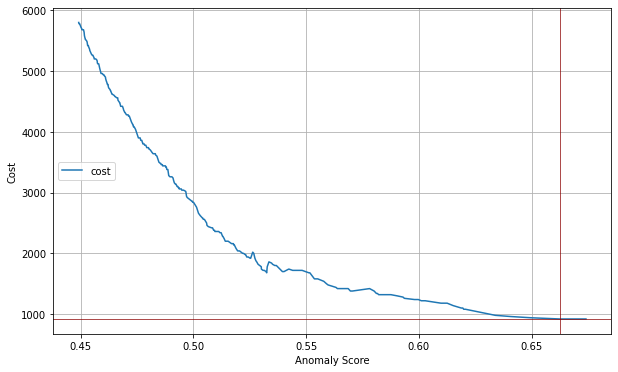

Component 3의 최소 비용 thresholds: 0.6626
Component 3의 최소 비용: 920
Cost for component 4


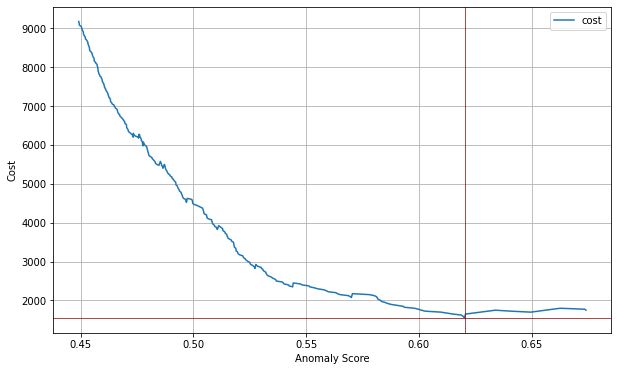

Component 4의 최소 비용 thresholds: 0.6203
Component 4의 최소 비용: 1550

모델 적용 시 소요 비용: 6365
Base cost: 12590
모델 적용 시 비용 절감량: 6225
비용 절감율: 49.44%


In [81]:
cost_list = list()
for comp in isol_model_list:
    print(f"Cost for component {comp['component']}")
    
    thre1, cost1 = cost_curve(y_val.iloc[:, comp['component']-1], comp['val_score'], thresholds, comp['component'])
    cost_list.append(cost1)
    print(f"Component {comp['component']}의 최소 비용 thresholds:", thre1)
    print(f"Component {comp['component']}의 최소 비용:", cost1)

total_cost = np.array(cost_list).sum()

print("")
print("모델 적용 시 소요 비용:", total_cost)
print("Base cost:", base_cost)
print("모델 적용 시 비용 절감량:", base_cost - total_cost)
print(f"비용 절감율: {round((base_cost - total_cost)/base_cost*100, 2)}%")

In [82]:
print("고장난 component만 고칠 때 Base cost", base_cost_2)
print("모델 적용 시 비용 절감량:", base_cost_2 - total_cost)
print(f"비용 절감율: {round((base_cost_2 - total_cost)/base_cost_2*100, 2)}%")

고장난 component만 고칠 때 Base cost 7045
모델 적용 시 비용 절감량: 680
비용 절감율: 9.65%


### One-Class SVM

In [83]:
### Normal data 추출을 위한 index reset
y_train = y_train.reset_index(drop=True)
x_train_cleaned = x_train_cleaned.reset_index(drop=True)

In [84]:
svm_model_list = list()
for i in range(y_val.shape[1]):
    print(f'<Result for X{i+1}>')
    
    x_train0 = x_train_cleaned[y_train.iloc[:, i].astype(int)==0]
    
    model2 = OneClassSVM()
    model2.fit(x_train0)
    
    pred2 = model2.predict(x_val_cleaned)
    pred2 = np.where(pred2==1, 0, 1) # -1, 1 ==> 1, 0
    
    cm = confusion_matrix(y_val.iloc[:, i], pred2)
    f1 = f1_score(y_val.iloc[:, i], pred2)
    print(cm)
    print('-'*50)
    print(classification_report(y_val.iloc[:, i], pred2))
    print(f1)
    
    svm_model_list.append({"component": i+1, "model": model2, "f1": f1, "cm": cm})

<Result for X1>
[[1479 1606]
 [   7    8]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.48      0.65      3085
         1.0       0.00      0.53      0.01        15

    accuracy                           0.48      3100
   macro avg       0.50      0.51      0.33      3100
weighted avg       0.99      0.48      0.64      3100

0.009821976672805401
<Result for X2>
[[1480 1599]
 [   8   13]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.48      0.65      3079
         1.0       0.01      0.62      0.02        21

    accuracy                           0.48      3100
   macro avg       0.50      0.55      0.33      3100
weighted avg       0.99      0.48      0.64      3100

0.0159216166564605
<Result for X3>
[[1488 1605]
 [   1    6]]
--------------------------------------------------
              precision 

In [85]:
svm_model_list = list()
for i in range(y_val.shape[1]):
    print(f'<Result for X{i+1}>')
    
    x_train0 = x_train_cleaned[y_train.iloc[:, i].astype(int)==0]
    
    nu = [0.001, 0.01, 0.05, 0.1]
    gamma = [0.001, 0.01, 0.05]
    items = [nu, gamma] 
    params = list(product(*items))
    
    f1_list = []
    for p in tqdm(params) :
        model = OneClassSVM(nu=p[0], gamma=p[1])
        model.fit(x_train0)
    
        pred = model.predict(x_val_cleaned)
        pred = np.where(pred==1, 0, 1)
        f1_list.append(f1_score(y_val.iloc[:, i], pred, pos_label=1))
        
    max_id = np.argmax(f1_list)
    print(params[max_id])
    print(f1_list[max_id])
    
    model2 = OneClassSVM(nu=params[max_id][0], gamma=params[max_id][1])
    model2.fit(x_train0)
    
    pred2 = model2.predict(x_val_cleaned)
    pred2 = np.where(pred2==1, 0, 1) # -1, 1 ==> 1, 0
    
    cm = confusion_matrix(y_val.iloc[:, i], pred2)
    f1 = f1_score(y_val.iloc[:, i], pred2)
    print(cm)
    print('-'*50)
    print(classification_report(y_val.iloc[:, i], pred2))
    print(f1)
    
    svm_model_list.append({"component": i+1, "model": model2, "f1_max": f1, "cm": cm})

<Result for X1>


100%|████████████████████████████████████| 12/12 [26:22<00:00, 131.89s/it]


(0.01, 0.001)
0.02553191489361702
[[2636  449]
 [   9    6]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      3085
         1.0       0.01      0.40      0.03        15

    accuracy                           0.85      3100
   macro avg       0.50      0.63      0.47      3100
weighted avg       0.99      0.85      0.92      3100

0.02553191489361702
<Result for X2>


100%|████████████████████████████████████| 12/12 [25:36<00:00, 128.03s/it]


(0.001, 0.001)
0.025263157894736845
[[2631  448]
 [  15    6]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      3079
         1.0       0.01      0.29      0.03        21

    accuracy                           0.85      3100
   macro avg       0.50      0.57      0.47      3100
weighted avg       0.99      0.85      0.91      3100

0.025263157894736845
<Result for X3>


100%|█████████████████████████████████| 12/12 [3:52:52<00:00, 1164.37s/it]


(0.05, 0.01)
0.006718924972004478
[[1320 1773]
 [   1    6]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.43      0.60      3093
         1.0       0.00      0.86      0.01         7

    accuracy                           0.43      3100
   macro avg       0.50      0.64      0.30      3100
weighted avg       1.00      0.43      0.60      3100

0.006718924972004478
<Result for X4>


100%|████████████████████████████████| 12/12 [10:19:58<00:00, 3099.84s/it]


(0.1, 0.001)
0.013745704467353952
[[2522  564]
 [  10    4]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90      3086
         1.0       0.01      0.29      0.01        14

    accuracy                           0.81      3100
   macro avg       0.50      0.55      0.46      3100
weighted avg       0.99      0.81      0.89      3100

0.013745704467353952


In [86]:
cost_list = list()
for i in range(y_val.shape[1]):
    print(f'<Result for X{i+1}>')
    
    x_train0 = x_train_cleaned[y_train.iloc[:, i].astype(int)==0]
    
    nu = [0.001, 0.01, 0.05, 0.1]
    gamma = [0.001, 0.01, 0.05]
    items = [nu, gamma] 
    params = list(product(*items))
    
    cost_matrix_comp = [[cost_matrix[0][0][i], cost_matrix[0][1][i]],
                        [cost_matrix[1][0][i], cost_matrix[1][1][i]]]
    
    tmp_cost_list = []
    for p in tqdm(params) :
        model=OneClassSVM(nu=p[0], gamma=p[1])
        model.fit(x_train0)
    
        pred = model.predict(x_val_cleaned)
        pred = np.where(pred==1, 0, 1)
        
        cost = (cm * cost_matrix_comp).sum()
        tmp_cost_list.append(cost)
        
    min_id = np.argmin(tmp_cost_list)
    print(params[min_id])
    print(tmp_cost_list[min_id])
    
    model2 = OneClassSVM(nu=params[min_id][0], gamma=params[min_id][1])
    model2.fit(x_train0)
    
    pred2 = model2.predict(x_val_cleaned)
    pred2 = np.where(pred2==1, 0, 1) # -1, 1 ==> 1, 0
    
    cm = confusion_matrix(y_val.iloc[:, i], pred2)
    f1 = f1_score(y_val.iloc[:, i], pred2)
    print(cm)
    print('-'*50)
    print(classification_report(y_val.iloc[:, i], pred2))
    print(f1)
    
    cost_list.append(tmp_cost_list[min_id])

total_cost = np.array(cost_list).sum()

print("")
print("모델 적용 시 소요 비용:", total_cost)
print("Base cost:", base_cost)
print("모델 적용 시 비용 절감량:", base_cost - total_cost)
print(f"비용 절감율: {round((base_cost - total_cost)/base_cost*100, 2)}%")

<Result for X1>


100%|████████████████████████████████████| 12/12 [26:50<00:00, 134.18s/it]


(0.001, 0.001)
9670
[[2633  452]
 [  10    5]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      3085
         1.0       0.01      0.33      0.02        15

    accuracy                           0.85      3100
   macro avg       0.50      0.59      0.47      3100
weighted avg       0.99      0.85      0.91      3100

0.0211864406779661
<Result for X2>


100%|████████████████████████████████████| 12/12 [26:36<00:00, 133.04s/it]


(0.001, 0.001)
15010
[[2631  448]
 [  15    6]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.92      3079
         1.0       0.01      0.29      0.03        21

    accuracy                           0.85      3100
   macro avg       0.50      0.57      0.47      3100
weighted avg       0.99      0.85      0.91      3100

0.025263157894736845
<Result for X3>


100%|████████████████████████████████████| 12/12 [26:04<00:00, 130.37s/it]


(0.001, 0.001)
10880
[[2642  451]
 [   7    0]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      3093
         1.0       0.00      0.00      0.00         7

    accuracy                           0.85      3100
   macro avg       0.50      0.43      0.46      3100
weighted avg       1.00      0.85      0.92      3100

0.0
<Result for X4>


100%|████████████████████████████████████| 12/12 [25:57<00:00, 129.80s/it]


(0.001, 0.001)
12150
[[2640  446]
 [  12    2]]
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92      3086
         1.0       0.00      0.14      0.01        14

    accuracy                           0.85      3100
   macro avg       0.50      0.50      0.46      3100
weighted avg       0.99      0.85      0.92      3100

0.008658008658008656

모델 적용 시 소요 비용: 47710
Base cost: 12590
모델 적용 시 비용 절감량: -35120
비용 절감율: -278.95%


In [87]:
print("고장난 component만 고칠 때 Base cost", base_cost_2)
print("모델 적용 시 비용 절감량:", base_cost_2 - total_cost)
print(f"비용 절감율: {round((base_cost_2 - total_cost)/base_cost_2*100, 2)}%")

고장난 component만 고칠 때 Base cost 7045
모델 적용 시 비용 절감량: -40665
비용 절감율: -577.22%


### LSTM-AE

In [88]:
seq_size = 3
drop_list = ['Date', 'M_ID']

def drop_columns(data):
    for column in drop_list:
        if column in data.columns:
            data = data.drop(column, axis=1)
            
    return data

## generate data sequence
def temporalize(x, y, timestep):
    output_X = []
    output_y = []
    for i in range(len(x) - timestep + 1):
        t = []
        for j in range(timestep):
            t.append(x[[(i + j)], :])
        output_X.append(t)
        output_y.append(y[i + timestep - 1])
    return np.squeeze(np.array(output_X)), np.array(output_y)

def to_sequences(data, target, train=False): # Number of time steps to look back
    sub_df_list = get_sub_df(data)
            
    # sub-dataframe seq 전환
    for i, sub_df in enumerate(sub_df_list):
        if len(sub_df) < seq_size:
            continue
            
        # 컬럼 제거
        sub_df = drop_columns(sub_df)
        
        if train:
            sub_df = sub_df[sub_df[target]==0]
            
        x = np.array(sub_df.drop(target, axis=1))
        y = sub_df[target]

        seq_x, seq_y = temporalize(x, list(y), seq_size)
            
        if i==0:
            total_seq_x = seq_x
            total_seq_y = seq_y
        else:
            try:
                total_seq_x = np.append(total_seq_x, seq_x, axis=0)
                total_seq_y = np.append(total_seq_y, seq_y, axis=0)

            except ValueError as e:
                print(e)

    return total_seq_x, total_seq_y

Epoch 1/10
6645/6645 [==============================] - 65s 9ms/step - loss: 78.5004
Epoch 2/10
6645/6645 [==============================] - 56s 8ms/step - loss: 6.2143
Epoch 3/10
6645/6645 [==============================] - 55s 8ms/step - loss: 1.9621
Epoch 4/10
6645/6645 [==============================] - 49s 7ms/step - loss: 1.1579
Epoch 5/10
6645/6645 [==============================] - 53s 8ms/step - loss: 0.8873
Epoch 6/10
6645/6645 [==============================] - 55s 8ms/step - loss: 0.7652
Epoch 7/10
6645/6645 [==============================] - 56s 8ms/step - loss: 0.6881
Epoch 8/10
6645/6645 [==============================] - 59s 9ms/step - loss: 0.6383
Epoch 9/10
6645/6645 [==============================] - 61s 9ms/step - loss: 0.5962
Epoch 10/10
97/97 [==============================] - 3s 5ms/step


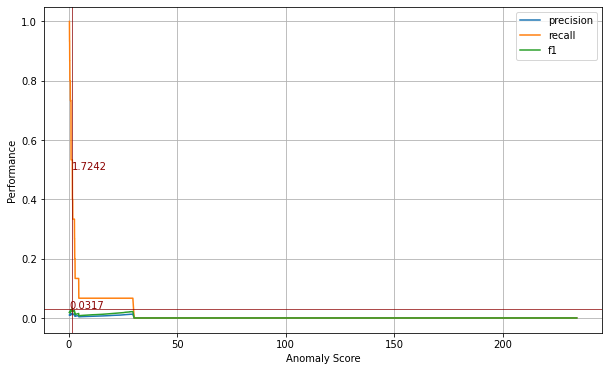

1.7241800749264686 0.031683168316831684
< confusion matrix >

[[2601  482]
 [   8    7]]


< classification_report >

              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      3083
         1.0       0.01      0.47      0.03        15

    accuracy                           0.84      3098
   macro avg       0.51      0.66      0.47      3098
weighted avg       0.99      0.84      0.91      3098



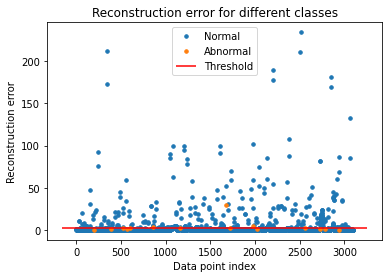

Epoch 1/10
6632/6632 [==============================] - 47s 6ms/step - loss: 76.4114
Epoch 2/10
6632/6632 [==============================] - 40s 6ms/step - loss: 6.3126
Epoch 3/10
6632/6632 [==============================] - 40s 6ms/step - loss: 2.0330
Epoch 4/10
6632/6632 [==============================] - 40s 6ms/step - loss: 1.2342
Epoch 5/10
6632/6632 [==============================] - 41s 6ms/step - loss: 0.9260
Epoch 6/10
6632/6632 [==============================] - 40s 6ms/step - loss: 0.8076
Epoch 7/10
6632/6632 [==============================] - 40s 6ms/step - loss: 0.6936
Epoch 8/10
6632/6632 [==============================] - 42s 6ms/step - loss: 0.6515
Epoch 9/10
6632/6632 [==============================] - 44s 7ms/step - loss: 0.5998
Epoch 10/10
97/97 [==============================] - 2s 6ms/step


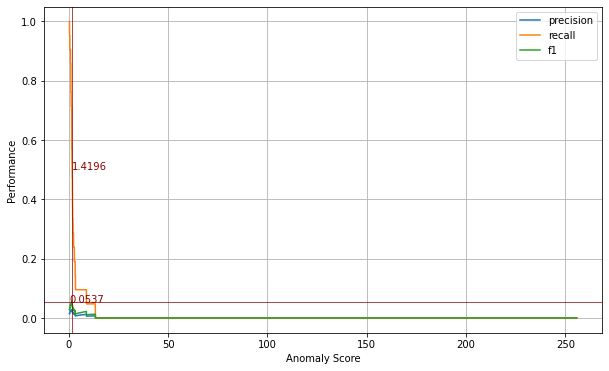

1.4195820409116844 0.053667262969588556
< confusion matrix >

[[2554  523]
 [   7   14]]


< classification_report >

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91      3077
         1.0       0.03      0.67      0.05        21

    accuracy                           0.83      3098
   macro avg       0.51      0.75      0.48      3098
weighted avg       0.99      0.83      0.90      3098



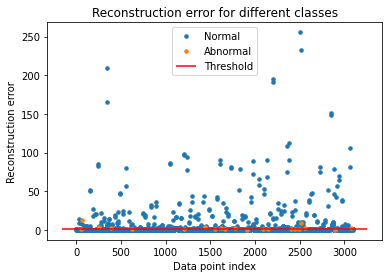

Epoch 1/10
6655/6655 [==============================] - 63s 8ms/step - loss: 77.9040
Epoch 2/10
6655/6655 [==============================] - 52s 8ms/step - loss: 6.2352
Epoch 3/10
6655/6655 [==============================] - 53s 8ms/step - loss: 2.2314
Epoch 4/10
6655/6655 [==============================] - 61s 9ms/step - loss: 1.2178
Epoch 5/10
6655/6655 [==============================] - 59s 9ms/step - loss: 0.8907
Epoch 6/10
6655/6655 [==============================] - 60s 9ms/step - loss: 0.7523
Epoch 7/10
6655/6655 [==============================] - 59s 9ms/step - loss: 0.7149
Epoch 8/10
6655/6655 [==============================] - 61s 9ms/step - loss: 0.6222
Epoch 9/10
6655/6655 [==============================] - 56s 8ms/step - loss: 0.5770
Epoch 10/10
97/97 [==============================] - 5s 7ms/step


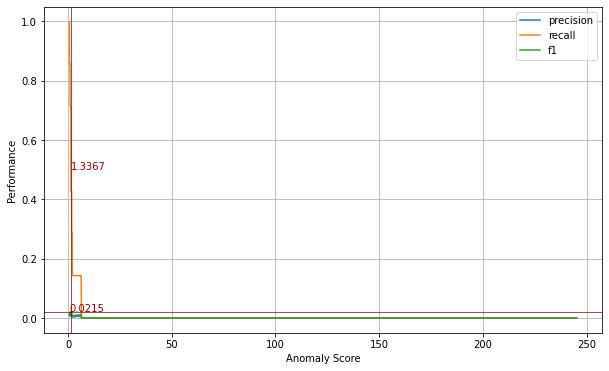

1.3366907571281157 0.02150537634408602
< confusion matrix >

[[2638  453]
 [   3    4]]


< classification_report >

              precision    recall  f1-score   support

         0.0       1.00      0.85      0.92      3091
         1.0       0.01      0.57      0.02         7

    accuracy                           0.85      3098
   macro avg       0.50      0.71      0.47      3098
weighted avg       1.00      0.85      0.92      3098



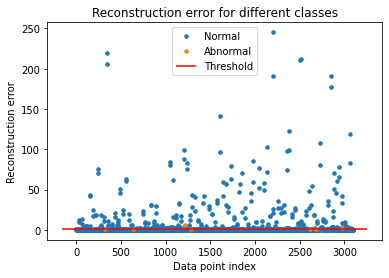

Epoch 1/10
6647/6647 [==============================] - 68s 9ms/step - loss: 117.5395
Epoch 2/10
6647/6647 [==============================] - 71s 11ms/step - loss: 16.2077
Epoch 3/10
6647/6647 [==============================] - 54s 8ms/step - loss: 3.4678
Epoch 4/10
6647/6647 [==============================] - 52s 8ms/step - loss: 1.7455
Epoch 5/10
6647/6647 [==============================] - 51s 8ms/step - loss: 1.1664
Epoch 6/10
6647/6647 [==============================] - 52s 8ms/step - loss: 0.9144
Epoch 7/10
6647/6647 [==============================] - 52s 8ms/step - loss: 0.8072
Epoch 8/10
6647/6647 [==============================] - 52s 8ms/step - loss: 0.7234
Epoch 9/10
6647/6647 [==============================] - 51s 8ms/step - loss: 0.6488
Epoch 10/10
97/97 [==============================] - 3s 5ms/step


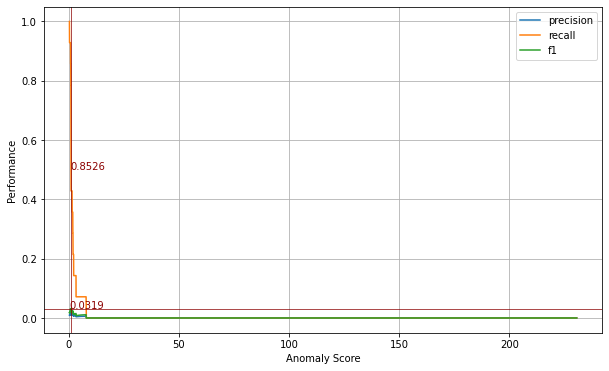

0.8526047506212807 0.03191489361702128
< confusion matrix >

[[2358  726]
 [   3   11]]


< classification_report >

              precision    recall  f1-score   support

         0.0       1.00      0.76      0.87      3084
         1.0       0.01      0.79      0.03        14

    accuracy                           0.76      3098
   macro avg       0.51      0.78      0.45      3098
weighted avg       0.99      0.76      0.86      3098



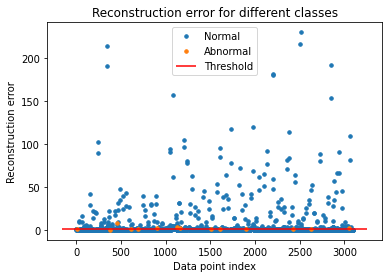

In [89]:
lstm_model_list = list()
for i, col in enumerate(fail_cols):
    x_seq, y_seq = to_sequences(train_data, col, train=True)
    x_seq_val, y_seq_val = to_sequences(valid_data, col)
    
    n_features = x_seq.shape[2]
    
    clear_session()

    # Encoder - Decoder
    model3 = Sequential([LSTM(128, input_shape = (seq_size, n_features), return_sequences=True),
                         LSTM(64, return_sequences=False),
                         RepeatVector(seq_size),
                         LSTM(64, return_sequences=True),
                         LSTM(128, return_sequences=True),
                         TimeDistributed(Dense(n_features))])
    
    model3.compile(optimizer='adam', loss = 'mse')
    model3.fit(x_seq, x_seq, epochs=10, batch_size=5, verbose=1)
    
    pred3 = model3.predict(x_seq_val)
    
    result1 = get_recon_err(x_seq_val, pred3, y_seq_val)
    _, _, f1, thresholds = prec_rec_f1_curve(result1['True_class'], result1['Recon_error'])
    
    print(thresholds[np.argmax(f1)], max(f1))
    thre = thresholds[np.argmax(f1)]
    cm = classification_report_with_cm(result1['True_class'], result1['Recon_error'], thre)
    recon_err_plot(result1, thre)
    
    lstm_model_list.append({"component": i+1, "model": model3, "f1_max": f1, "cm": cm,  "thresholds": thre, "true_class": result1['True_class'], "recon_error": result1['Recon_error']})

Cost for component 1


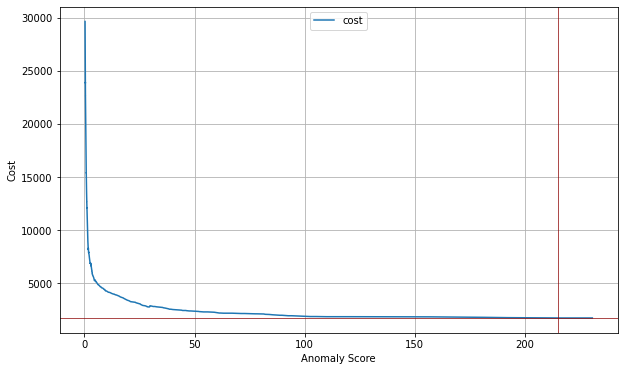

Component 1의 최소 비용 thresholds: 215.0847
Component 1의 최소 비용: 1740
Cost for component 2


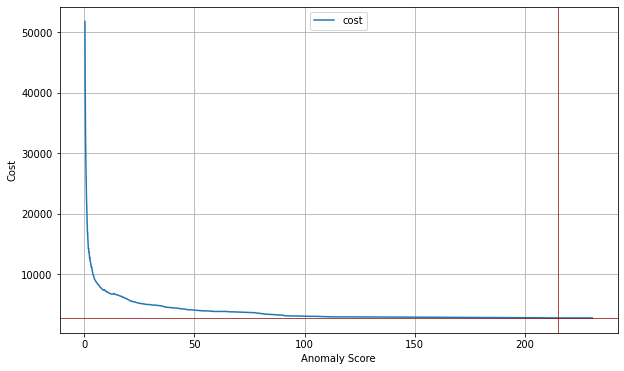

Component 2의 최소 비용 thresholds: 215.0847
Component 2의 최소 비용: 2790
Cost for component 3


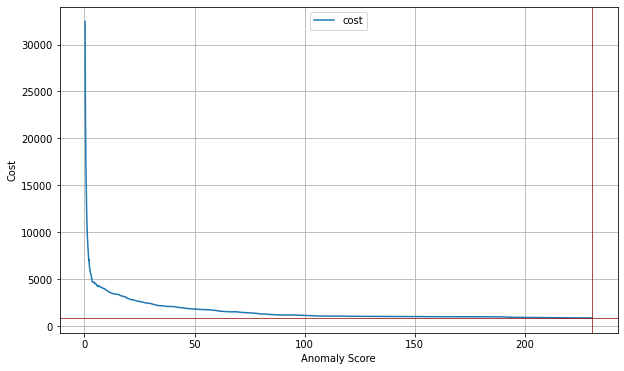

Component 3의 최소 비용 thresholds: 230.5795
Component 3의 최소 비용: 860
Cost for component 4


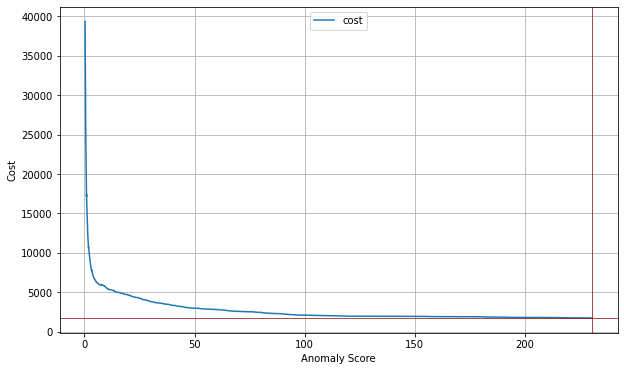

Component 4의 최소 비용 thresholds: 230.5795
Component 4의 최소 비용: 1750
모델 적용 시 소요 비용: 7140
Base cost: 12590
모델 적용 시 비용 절감량: 5450
비용 절감율: 43.29%


In [90]:
cost_list = list()
for comp in lstm_model_list:
    print(f"Cost for component {comp['component']}")
    
    thre1, cost1 = cost_curve(comp['true_class'], comp['recon_error'], thresholds, comp['component'])
    cost_list.append(cost1)
    print(f"Component {comp['component']}의 최소 비용 thresholds:", thre1)
    print(f"Component {comp['component']}의 최소 비용:", cost1)

total_cost = np.array(cost_list).sum()

print("모델 적용 시 소요 비용:", total_cost)
print("Base cost:", base_cost)
print("모델 적용 시 비용 절감량:", base_cost - total_cost)
print(f"비용 절감율: {round((base_cost - total_cost)/base_cost*100, 2)}%")

In [91]:
print("고장난 component만 고칠 때 Base cost", base_cost_2)
print("모델 적용 시 비용 절감량:", base_cost_2 - total_cost)
print(f"비용 절감율: {round((base_cost_2 - total_cost)/base_cost_2*100, 2)}%")

고장난 component만 고칠 때 Base cost 7045
모델 적용 시 비용 절감량: -95
비용 절감율: -1.35%


### CNN-AE

Epoch 1/10
1039/1039 [==============================] - 5s 4ms/step - loss: 18.2402
Epoch 2/10
1039/1039 [==============================] - 4s 4ms/step - loss: 1.0094
Epoch 3/10
1039/1039 [==============================] - 4s 3ms/step - loss: 0.3409
Epoch 4/10
1039/1039 [==============================] - 4s 4ms/step - loss: 0.2216
Epoch 5/10
1039/1039 [==============================] - 4s 3ms/step - loss: 0.1858
Epoch 6/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1696
Epoch 7/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1412
Epoch 8/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1673
Epoch 9/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1186
Epoch 10/10
97/97 [==============================] - 0s 2ms/step


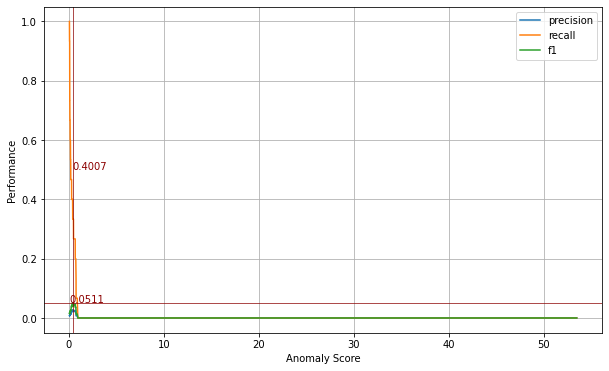

0.40071170692922137 0.05106382978723403
< confusion matrix >

[[2869  214]
 [  10    5]]


< classification_report >

              precision    recall  f1-score   support

         0.0       1.00      0.93      0.96      3083
         1.0       0.02      0.33      0.04        15

    accuracy                           0.93      3098
   macro avg       0.51      0.63      0.50      3098
weighted avg       0.99      0.93      0.96      3098



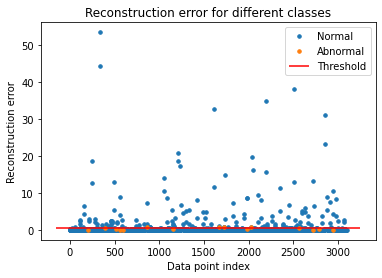

Epoch 1/10
1037/1037 [==============================] - 4s 3ms/step - loss: 13.6543
Epoch 2/10
1037/1037 [==============================] - 3s 3ms/step - loss: 0.7021
Epoch 3/10
1037/1037 [==============================] - 3s 3ms/step - loss: 0.2806
Epoch 4/10
1037/1037 [==============================] - 3s 3ms/step - loss: 0.2104
Epoch 5/10
1037/1037 [==============================] - 3s 3ms/step - loss: 0.1882
Epoch 6/10
1037/1037 [==============================] - 3s 3ms/step - loss: 0.1616
Epoch 7/10
1037/1037 [==============================] - 3s 3ms/step - loss: 0.1554
Epoch 8/10
1037/1037 [==============================] - 3s 3ms/step - loss: 0.1264
Epoch 9/10
1037/1037 [==============================] - 4s 3ms/step - loss: 0.1255
Epoch 10/10
97/97 [==============================] - 0s 2ms/step


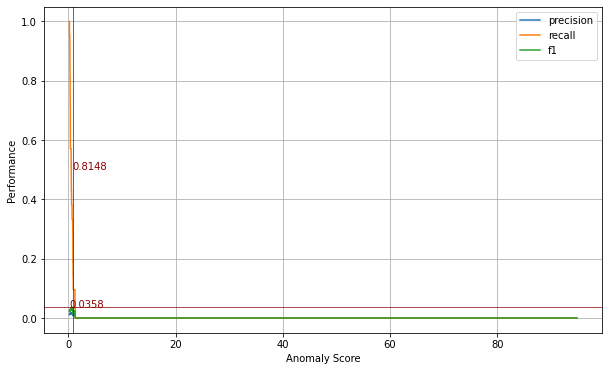

0.8147503140622119 0.03580562659846547
< confusion matrix >

[[2714  363]
 [  15    6]]


< classification_report >

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93      3077
         1.0       0.02      0.29      0.03        21

    accuracy                           0.88      3098
   macro avg       0.51      0.58      0.48      3098
weighted avg       0.99      0.88      0.93      3098



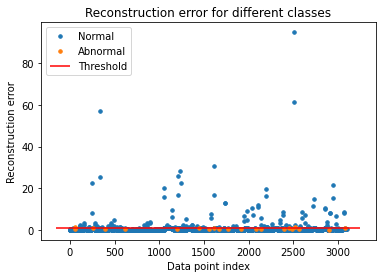

Epoch 1/10
1040/1040 [==============================] - 4s 4ms/step - loss: 16.0790
Epoch 2/10
1040/1040 [==============================] - 3s 3ms/step - loss: 1.0095
Epoch 3/10
1040/1040 [==============================] - 3s 3ms/step - loss: 0.3203
Epoch 4/10
1040/1040 [==============================] - 4s 4ms/step - loss: 0.2089
Epoch 5/10
1040/1040 [==============================] - 3s 3ms/step - loss: 0.1889
Epoch 6/10
1040/1040 [==============================] - 3s 3ms/step - loss: 0.1621
Epoch 7/10
1040/1040 [==============================] - 3s 3ms/step - loss: 0.1650
Epoch 8/10
1040/1040 [==============================] - 4s 3ms/step - loss: 0.1276
Epoch 9/10
1040/1040 [==============================] - 3s 3ms/step - loss: 0.1326
Epoch 10/10
97/97 [==============================] - 0s 2ms/step


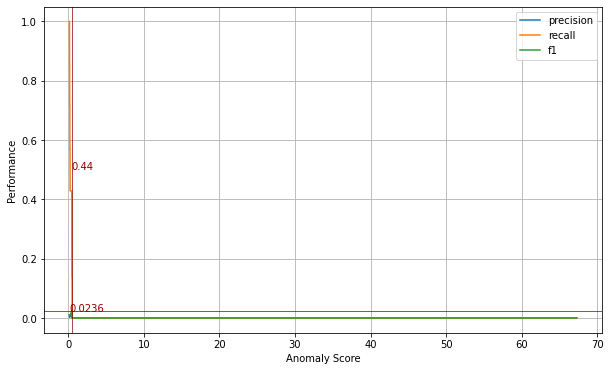

0.43995162239692925 0.02362204724409449
< confusion matrix >

[[2847  244]
 [   5    2]]


< classification_report >

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96      3091
         1.0       0.01      0.29      0.02         7

    accuracy                           0.92      3098
   macro avg       0.50      0.60      0.49      3098
weighted avg       1.00      0.92      0.96      3098



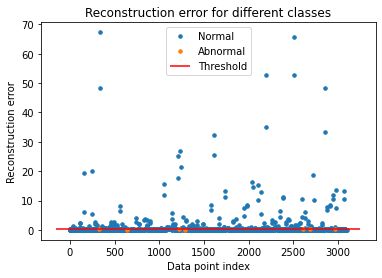

Epoch 1/10
1039/1039 [==============================] - 4s 4ms/step - loss: 14.7911
Epoch 2/10
1039/1039 [==============================] - 3s 3ms/step - loss: 1.4234
Epoch 3/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.4904
Epoch 4/10
1039/1039 [==============================] - 4s 4ms/step - loss: 0.2969
Epoch 5/10
1039/1039 [==============================] - 4s 4ms/step - loss: 0.2146
Epoch 6/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1818
Epoch 7/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1640
Epoch 8/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1430
Epoch 9/10
1039/1039 [==============================] - 3s 3ms/step - loss: 0.1426
Epoch 10/10
97/97 [==============================] - 0s 2ms/step


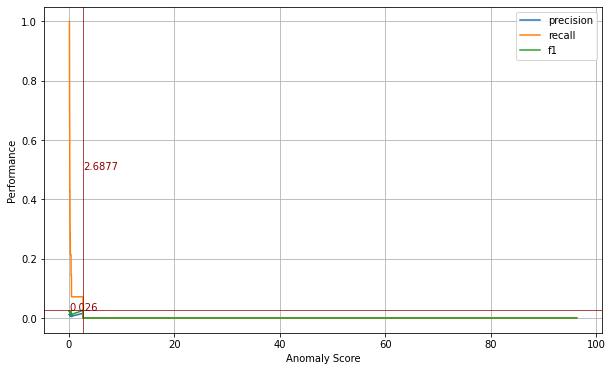

2.687653897943364 0.025974025974025976
< confusion matrix >

[[3022   62]
 [  14    0]]


< classification_report >

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      3084
         1.0       0.00      0.00      0.00        14

    accuracy                           0.98      3098
   macro avg       0.50      0.49      0.49      3098
weighted avg       0.99      0.98      0.98      3098



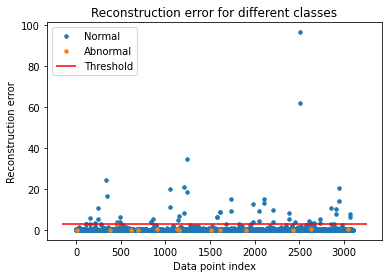

In [92]:
cnn_model_list = list()
for i, col in enumerate(fail_cols):
    x_seq, y_seq = to_sequences(train_data, col, train=True)
    x_seq_val, y_seq_val = to_sequences(valid_data, col)
    
    timesteps = x_seq.shape[1]
    n_features = x_seq.shape[2]
    
    clear_session()

    # Encoder - Decoder
    model4 = Sequential([Conv1D(32, 3, input_shape=(timesteps, n_features), 
                                activation='relu', padding = 'same'), 
                        Conv1D(16, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(16, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(32, 3, activation="relu", padding = 'same'),
                        Conv1DTranspose(n_features, 3, padding = 'same') ])
    
    model4.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse')
    model4.fit(x=x_seq, y=x_seq, epochs=10)
    
    pred4 = model4.predict(x_seq_val)
    
    result2 = get_recon_err(x_seq_val, pred4, y_seq_val)
    _, _, f1, thresholds = prec_rec_f1_curve(result2['True_class'], result2['Recon_error'])
    
    print(thresholds[np.argmax(f1)], max(f1))
    thre = thresholds[np.argmax(f1)]
    cm = classification_report_with_cm(result2['True_class'], result2['Recon_error'], thre)
    recon_err_plot(result2, thre)
    
    cnn_model_list.append({"component": i+1, "model": model4, "f1_max": f1, "cm": cm, "thresholds": thre, "true_class": result2['True_class'], "recon_error": result2['Recon_error']})

Cost for component 1


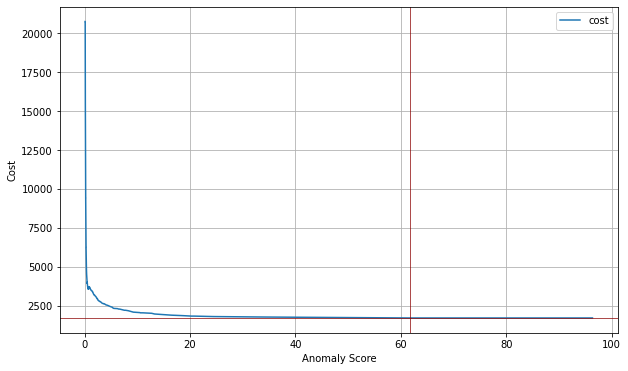

Component 1의 최소 비용 thresholds: 61.6464
Component 1의 최소 비용: 1725
Cost for component 2


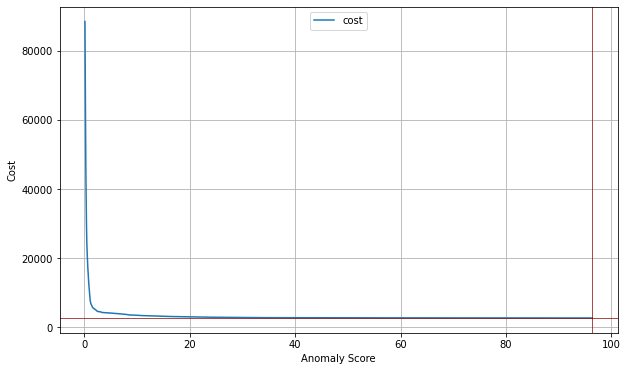

Component 2의 최소 비용 thresholds: 96.3562
Component 2의 최소 비용: 2730
Cost for component 3


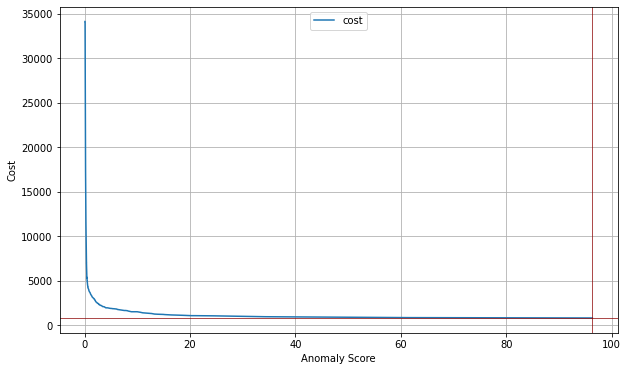

Component 3의 최소 비용 thresholds: 96.3562
Component 3의 최소 비용: 840
Cost for component 4


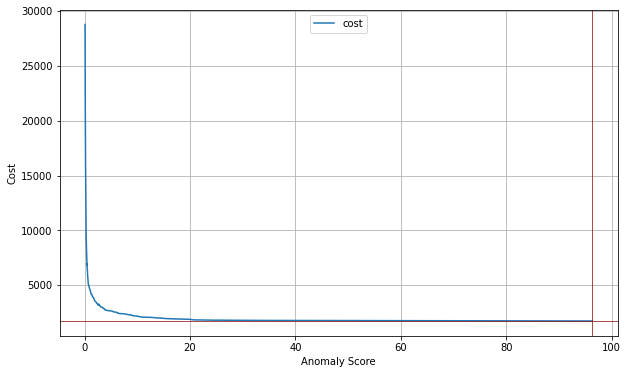

Component 4의 최소 비용 thresholds: 96.3562
Component 4의 최소 비용: 1750
모델 적용 시 소요 비용: 7045
Base cost: 12590
모델 적용 시 비용 절감량: 5545
비용 절감율: 44.04%


In [93]:
cost_list = list()
for comp in cnn_model_list:
    print(f"Cost for component {comp['component']}")
    
    thre1, cost1 = cost_curve(comp['true_class'], comp['recon_error'], thresholds, comp['component'])
    cost_list.append(cost1)
    print(f"Component {comp['component']}의 최소 비용 thresholds:", thre1)
    print(f"Component {comp['component']}의 최소 비용:", cost1)

total_cost = np.array(cost_list).sum()

print("모델 적용 시 소요 비용:", total_cost)
print("Base cost:", base_cost)
print("모델 적용 시 비용 절감량:", base_cost - total_cost)
print(f"비용 절감율: {round((base_cost - total_cost)/base_cost*100, 2)}%")

In [94]:
print("고장난 component만 고칠 때 Base cost", base_cost_2)
print("모델 적용 시 비용 절감량:", base_cost_2 - total_cost)
print(f"비용 절감율: {round((base_cost_2 - total_cost)/base_cost_2*100, 2)}%")

고장난 component만 고칠 때 Base cost 7045
모델 적용 시 비용 절감량: 0
비용 절감율: 0.0%
